## Preamble

In [1]:
import numpy as np
from scipy.optimize import leastsq
import cmath
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle, Wedge

import sys
import os
parent_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from field_map_g4bl import readFieldMapData
from compute_multipole_components import fitMultipoles, computeField

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../..'))
sys.path.append(parent_dir)
from functions.set_plot_settings import setPlotSettings
setPlotSettings(font=True)

In [2]:
# Path to field map files:
file = 'fieldmap.txt'
file_norot = 'fieldmap_norotations.txt'

# Animation directory:
ani_dir = 'animations/'

In [3]:
# Lattice parameters:
dist = 700 # spacing between solenoid centers (mm)
length = 300 # solenoid length (mm)
a = 420 # solenoid inner radius (mm)
b = 600 # solenoid outer radius (mm)

In [4]:
# Function to plot lattice -- notably without visible rotations:
def plotLattice(ax, label=False):
    for i in range(6):
        ax.axvspan(xmin=-length/2+dist*i, xmax=length/2+dist*i, color='lightgray', alpha=0.5)
        if label:
            if np.mod(i,2) == 0:
                ax.text(dist*i-30, 0.95, s='$+$')
            else:
                ax.text(dist*i-30, 0.95, s='$-$')

In [5]:
# Function to plot solenoid cross-sections -- notably without visible rotations:
def plotSolenoid(ax, color='white'):
    circle_inner = plt.Circle([0,0], radius=a, fill=False, linestyle='-', color=color)
    ax.add_patch(circle_inner)
    circle_outer = plt.Circle([0,0], radius=b, fill=False, linestyle='-', color=color)
    ax.add_patch(circle_outer)
    fill = Wedge(center=(0, 0), r=b, theta1=0, theta2=360, width=b - a, color=color, label='Solenoid', alpha=0.8)
    ax.add_patch(fill)
    ax.legend(loc='upper right')

## Compute multipole components from G4bl fieldmap

In [6]:
data = readFieldMapData(file)

x = np.unique(data['x'].values)
y = np.unique(data['y'].values)
X, Y = np.meshgrid(x, y)

In [7]:
def func(data, X, Y, R_ref=a):

    z_vals = np.arange(0, 4200, 10) # only one HFOFO period
    columns = ['z', 'n=1', 'n=2', 'n=3', 'n=4', 'n=5', 'n=6']
    rows = []
    rows2 = []

    for z in z_vals:

        data_slice = data[data['z'] == z]
        if data_slice.empty:
            continue

        Bx = data_slice.pivot_table(index='y', columns='x', values='Bx').values
        By = data_slice.pivot_table(index='y', columns='x', values='By').values

        max_order = len(columns)-1
        coeffs = fitMultipoles(X, Y, Bx, By, max_order=max_order, R=R_ref)
        coeffs_mag = [abs(coeffs[i]) for i in range(1, max_order+1)] # magnitude
        coeffs_phase = [cmath.phase(coeffs[i]) for i in range(1, max_order+1)] # phase
        rows.append([z] + coeffs_mag)
        rows2.append([z] + coeffs_phase)

    df = pd.DataFrame(rows, columns=columns)
    df2 = pd.DataFrame(rows2, columns=columns)

    return df, df2

In [8]:
df, df2 = func(data, X, Y)

## Plot coefficients vs. z

#### Magnitudes:

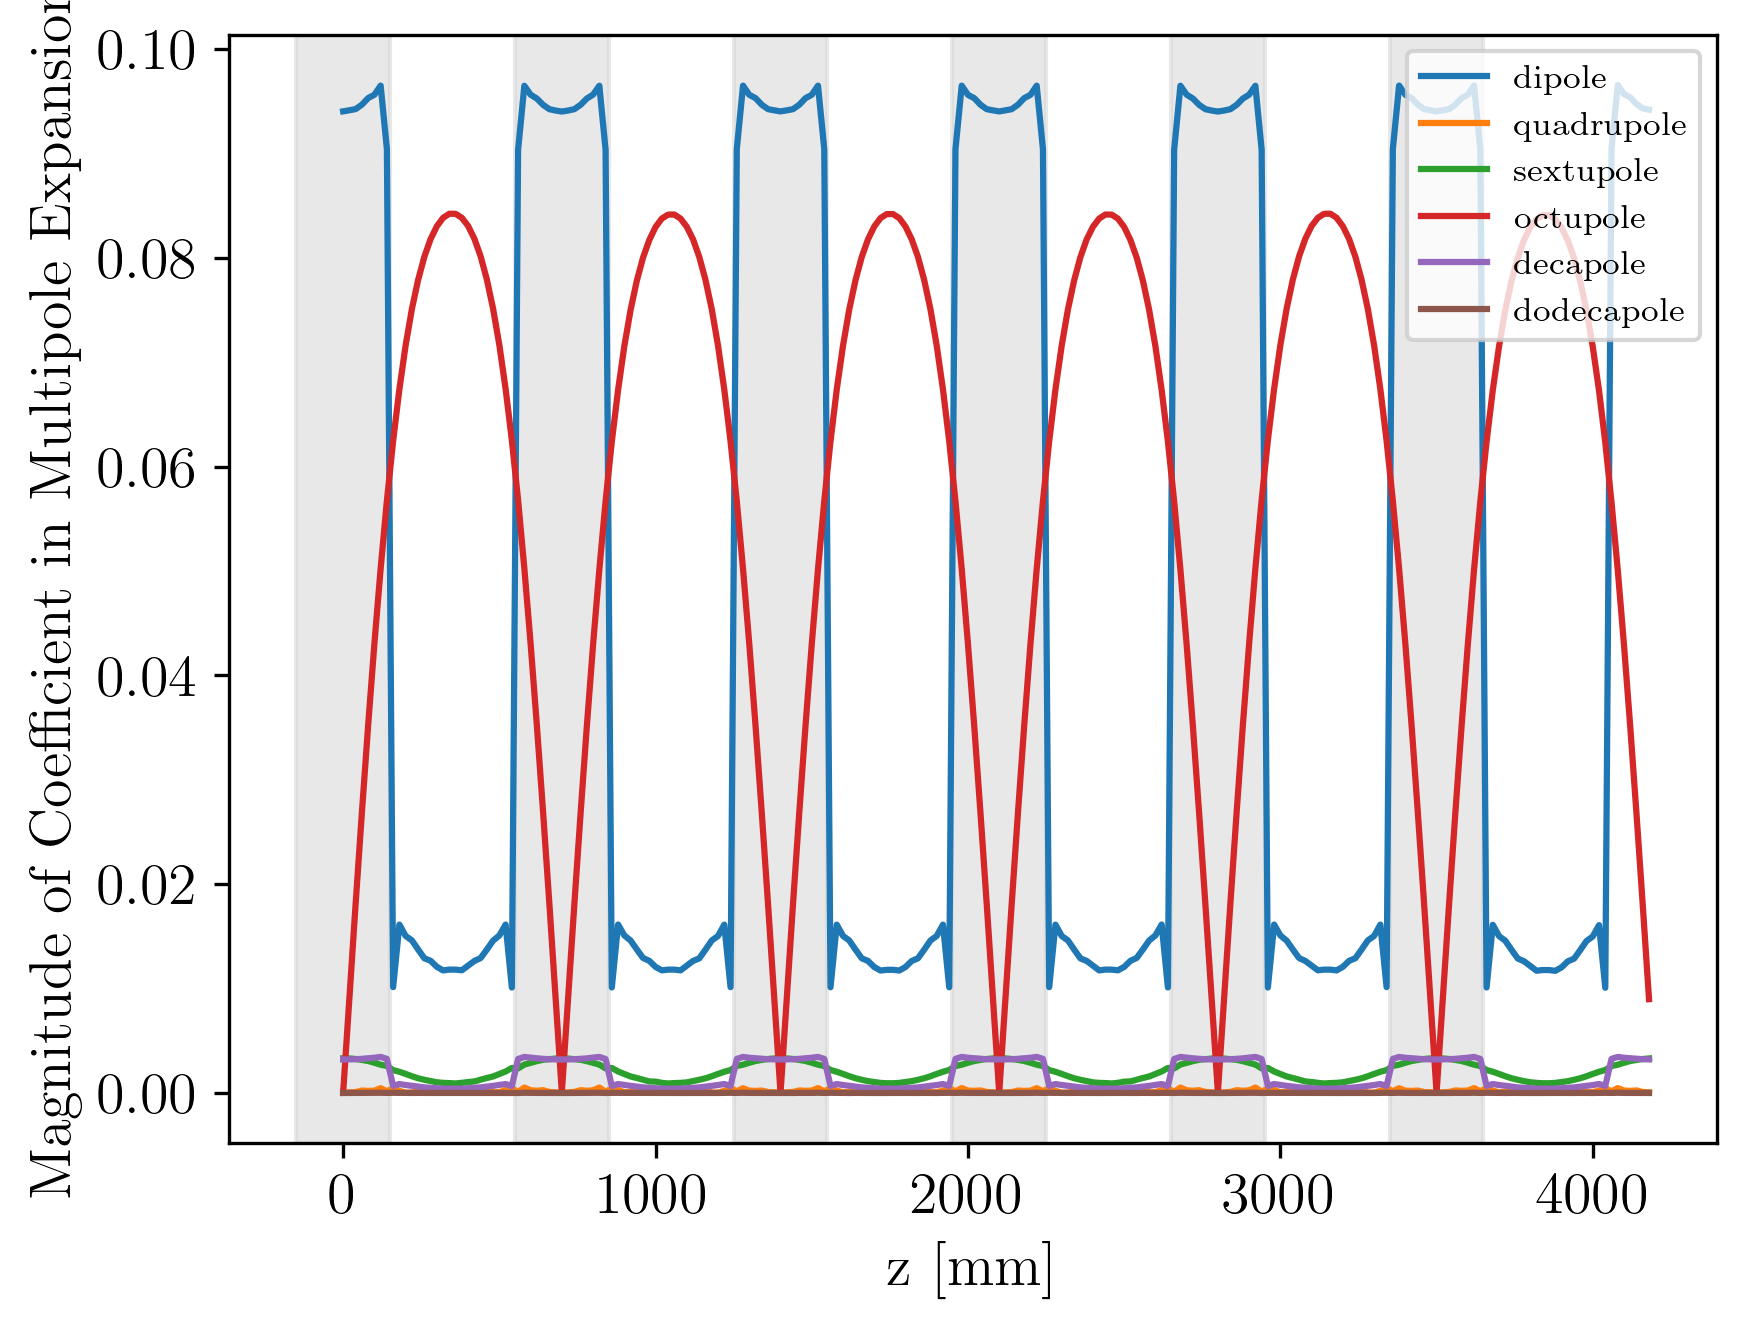

In [9]:
fig, ax = plt.subplots()
plt.plot(df['z'], df['n=1'], label='dipole')
plt.plot(df['z'], df['n=2'], label='quadrupole')
plt.plot(df['z'], df['n=3'], label='sextupole')
plt.plot(df['z'], df['n=4'], label='octupole')
plt.plot(df['z'], df['n=5'], label='decapole')
plt.plot(df['z'], df['n=6'], label='dodecapole')
plt.legend(fontsize=8, loc='upper right')
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

#### Phases:

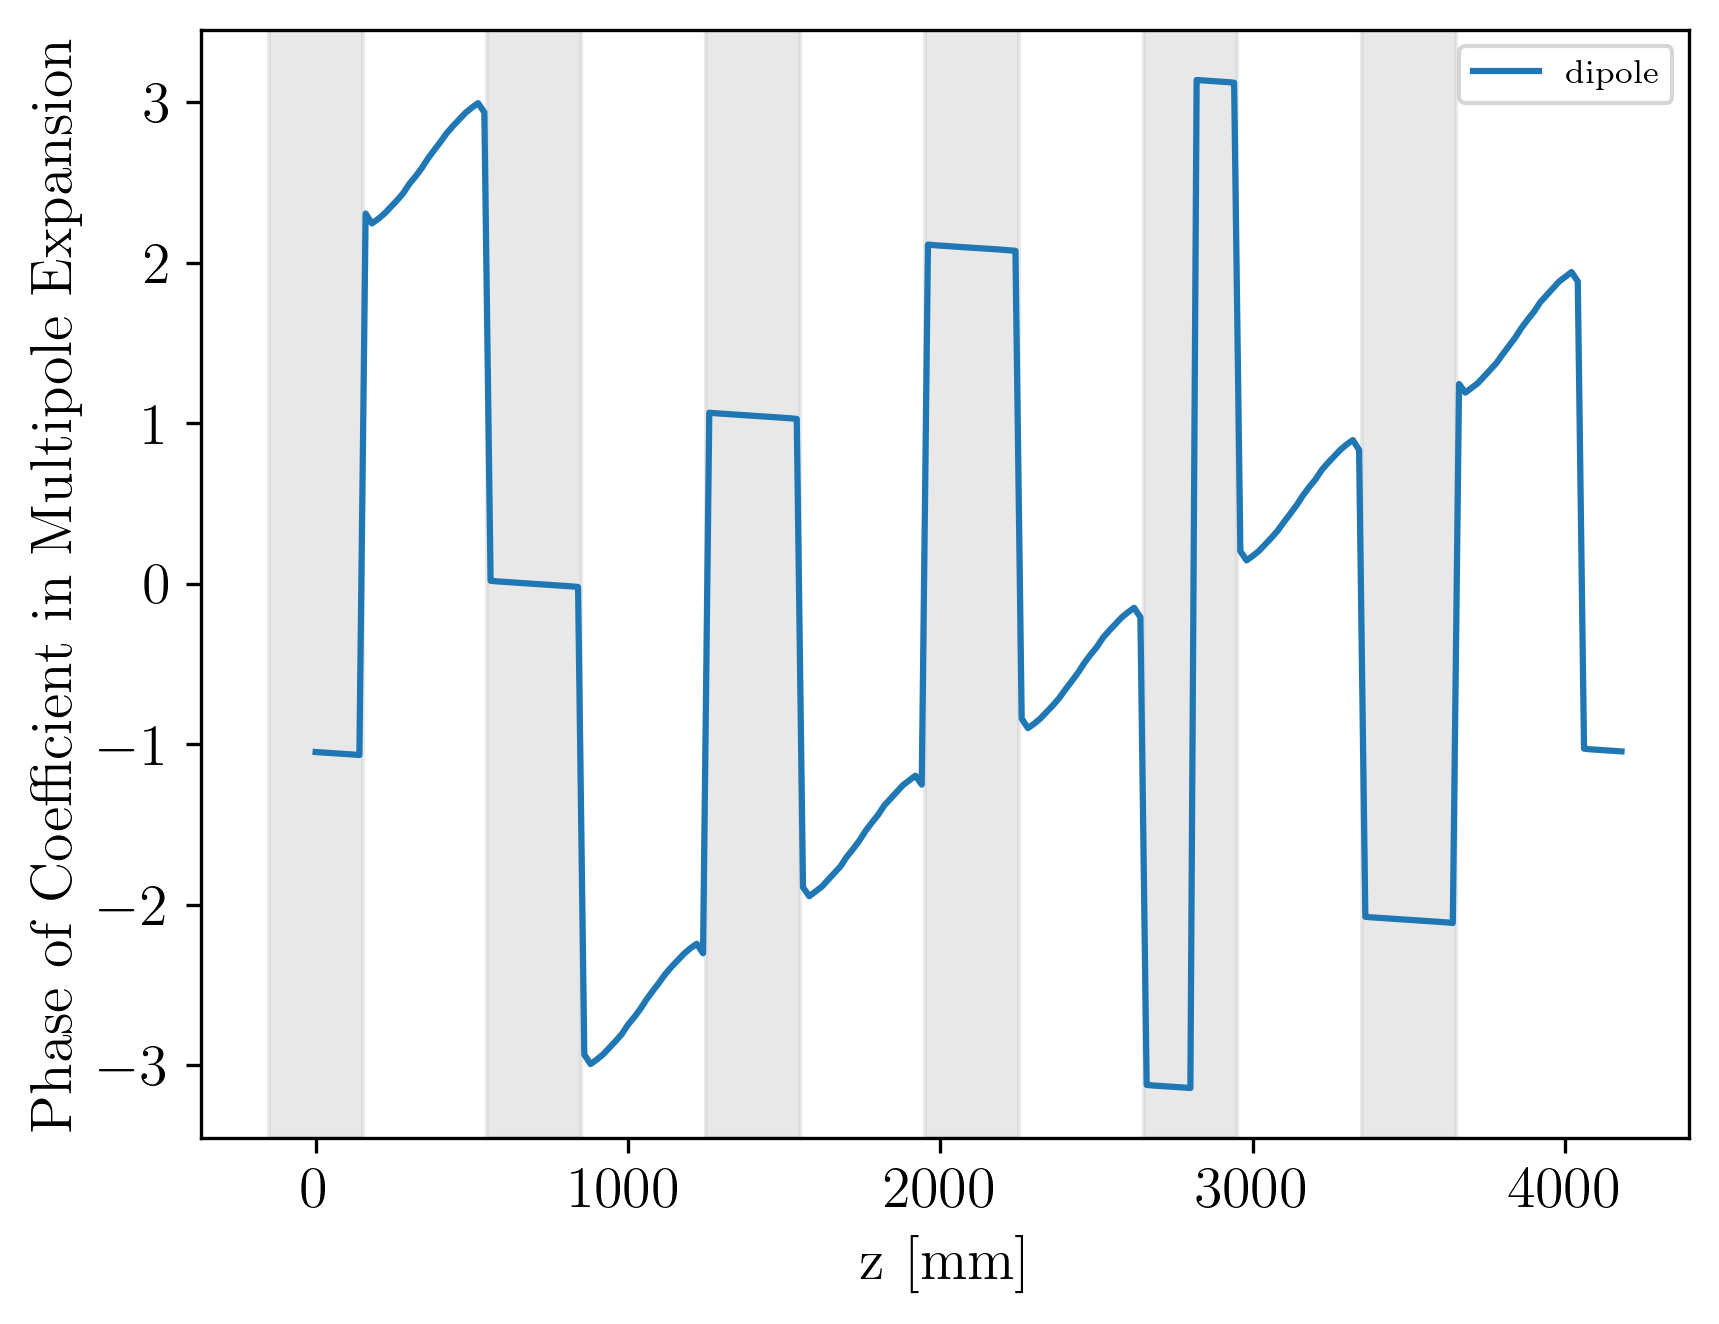

In [10]:
fig, ax = plt.subplots()
plt.plot(df2['z'], df2['n=1'], label='dipole', color='tab:blue')
plt.legend(fontsize=8, loc='upper right')
plt.xlabel('z [mm]')
plt.ylabel('Phase of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

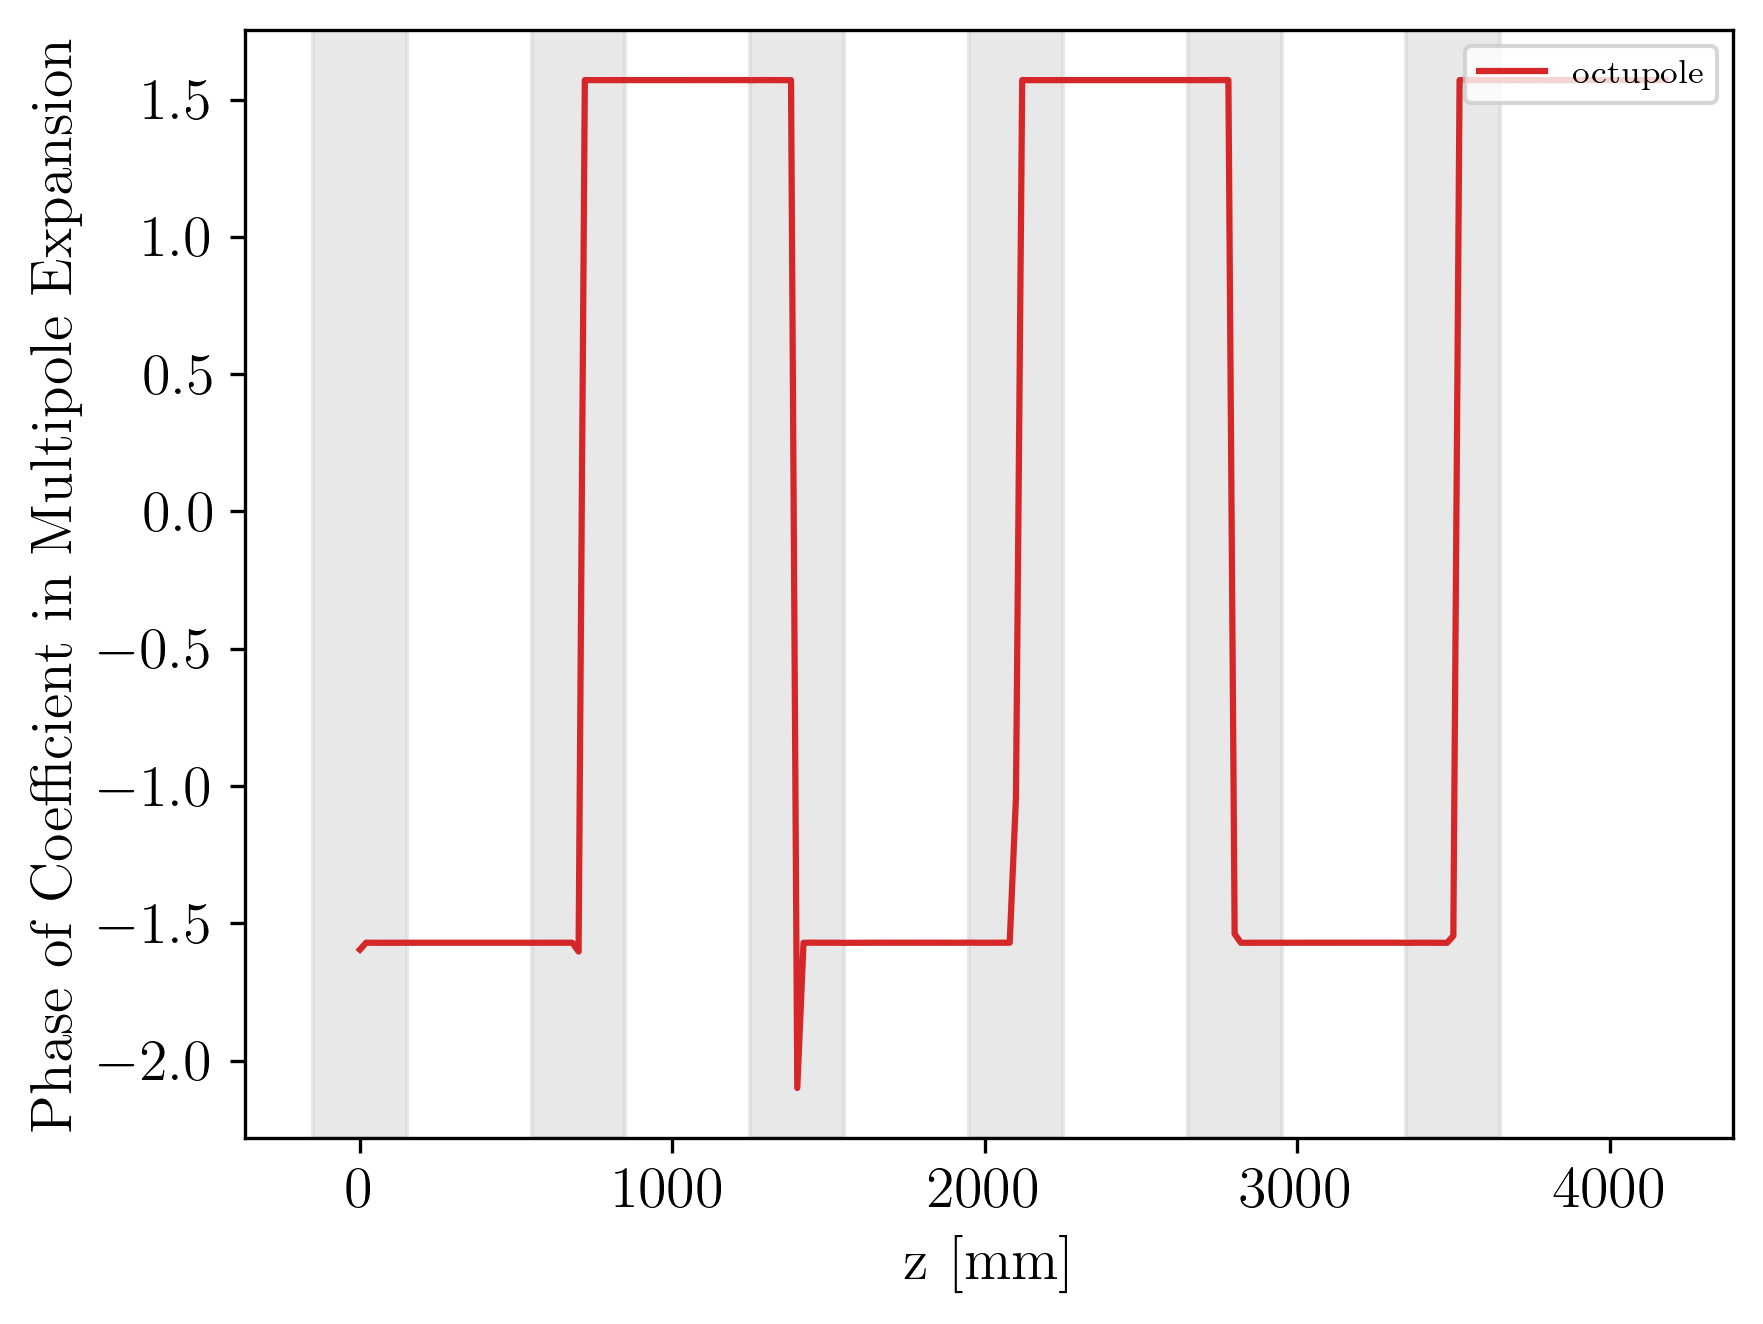

In [11]:
fig, ax = plt.subplots()
plt.plot(df2['z'], df2['n=4'], label='octupole', color='tab:red')
plt.legend(fontsize=8, loc='upper right')
plt.xlabel('z [mm]')
plt.ylabel('Phase of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

## Verify by computing field from multipole coefficients

In [12]:
Bx_by_z = []
By_by_z = []
B_by_z = []
for z in df['z'].values:

        coeff_list_mag = df.loc[np.where(df['z']==z)[0]].values[0][1:]
        coeff_list_phase = df2.loc[np.where(df2['z']==z)[0]].values[0][1:]

        Bx_slice, By_slice = computeField(x, y, coeff_list_mag, coeff_list_phase)
        Bx_by_z.append(Bx_slice)
        By_by_z.append(By_slice)
        theta = np.arctan2(By_slice, Bx_slice)
        B = Bx_slice*np.cos(theta) + By_slice*np.sin(theta)
        B_by_z.append(B)

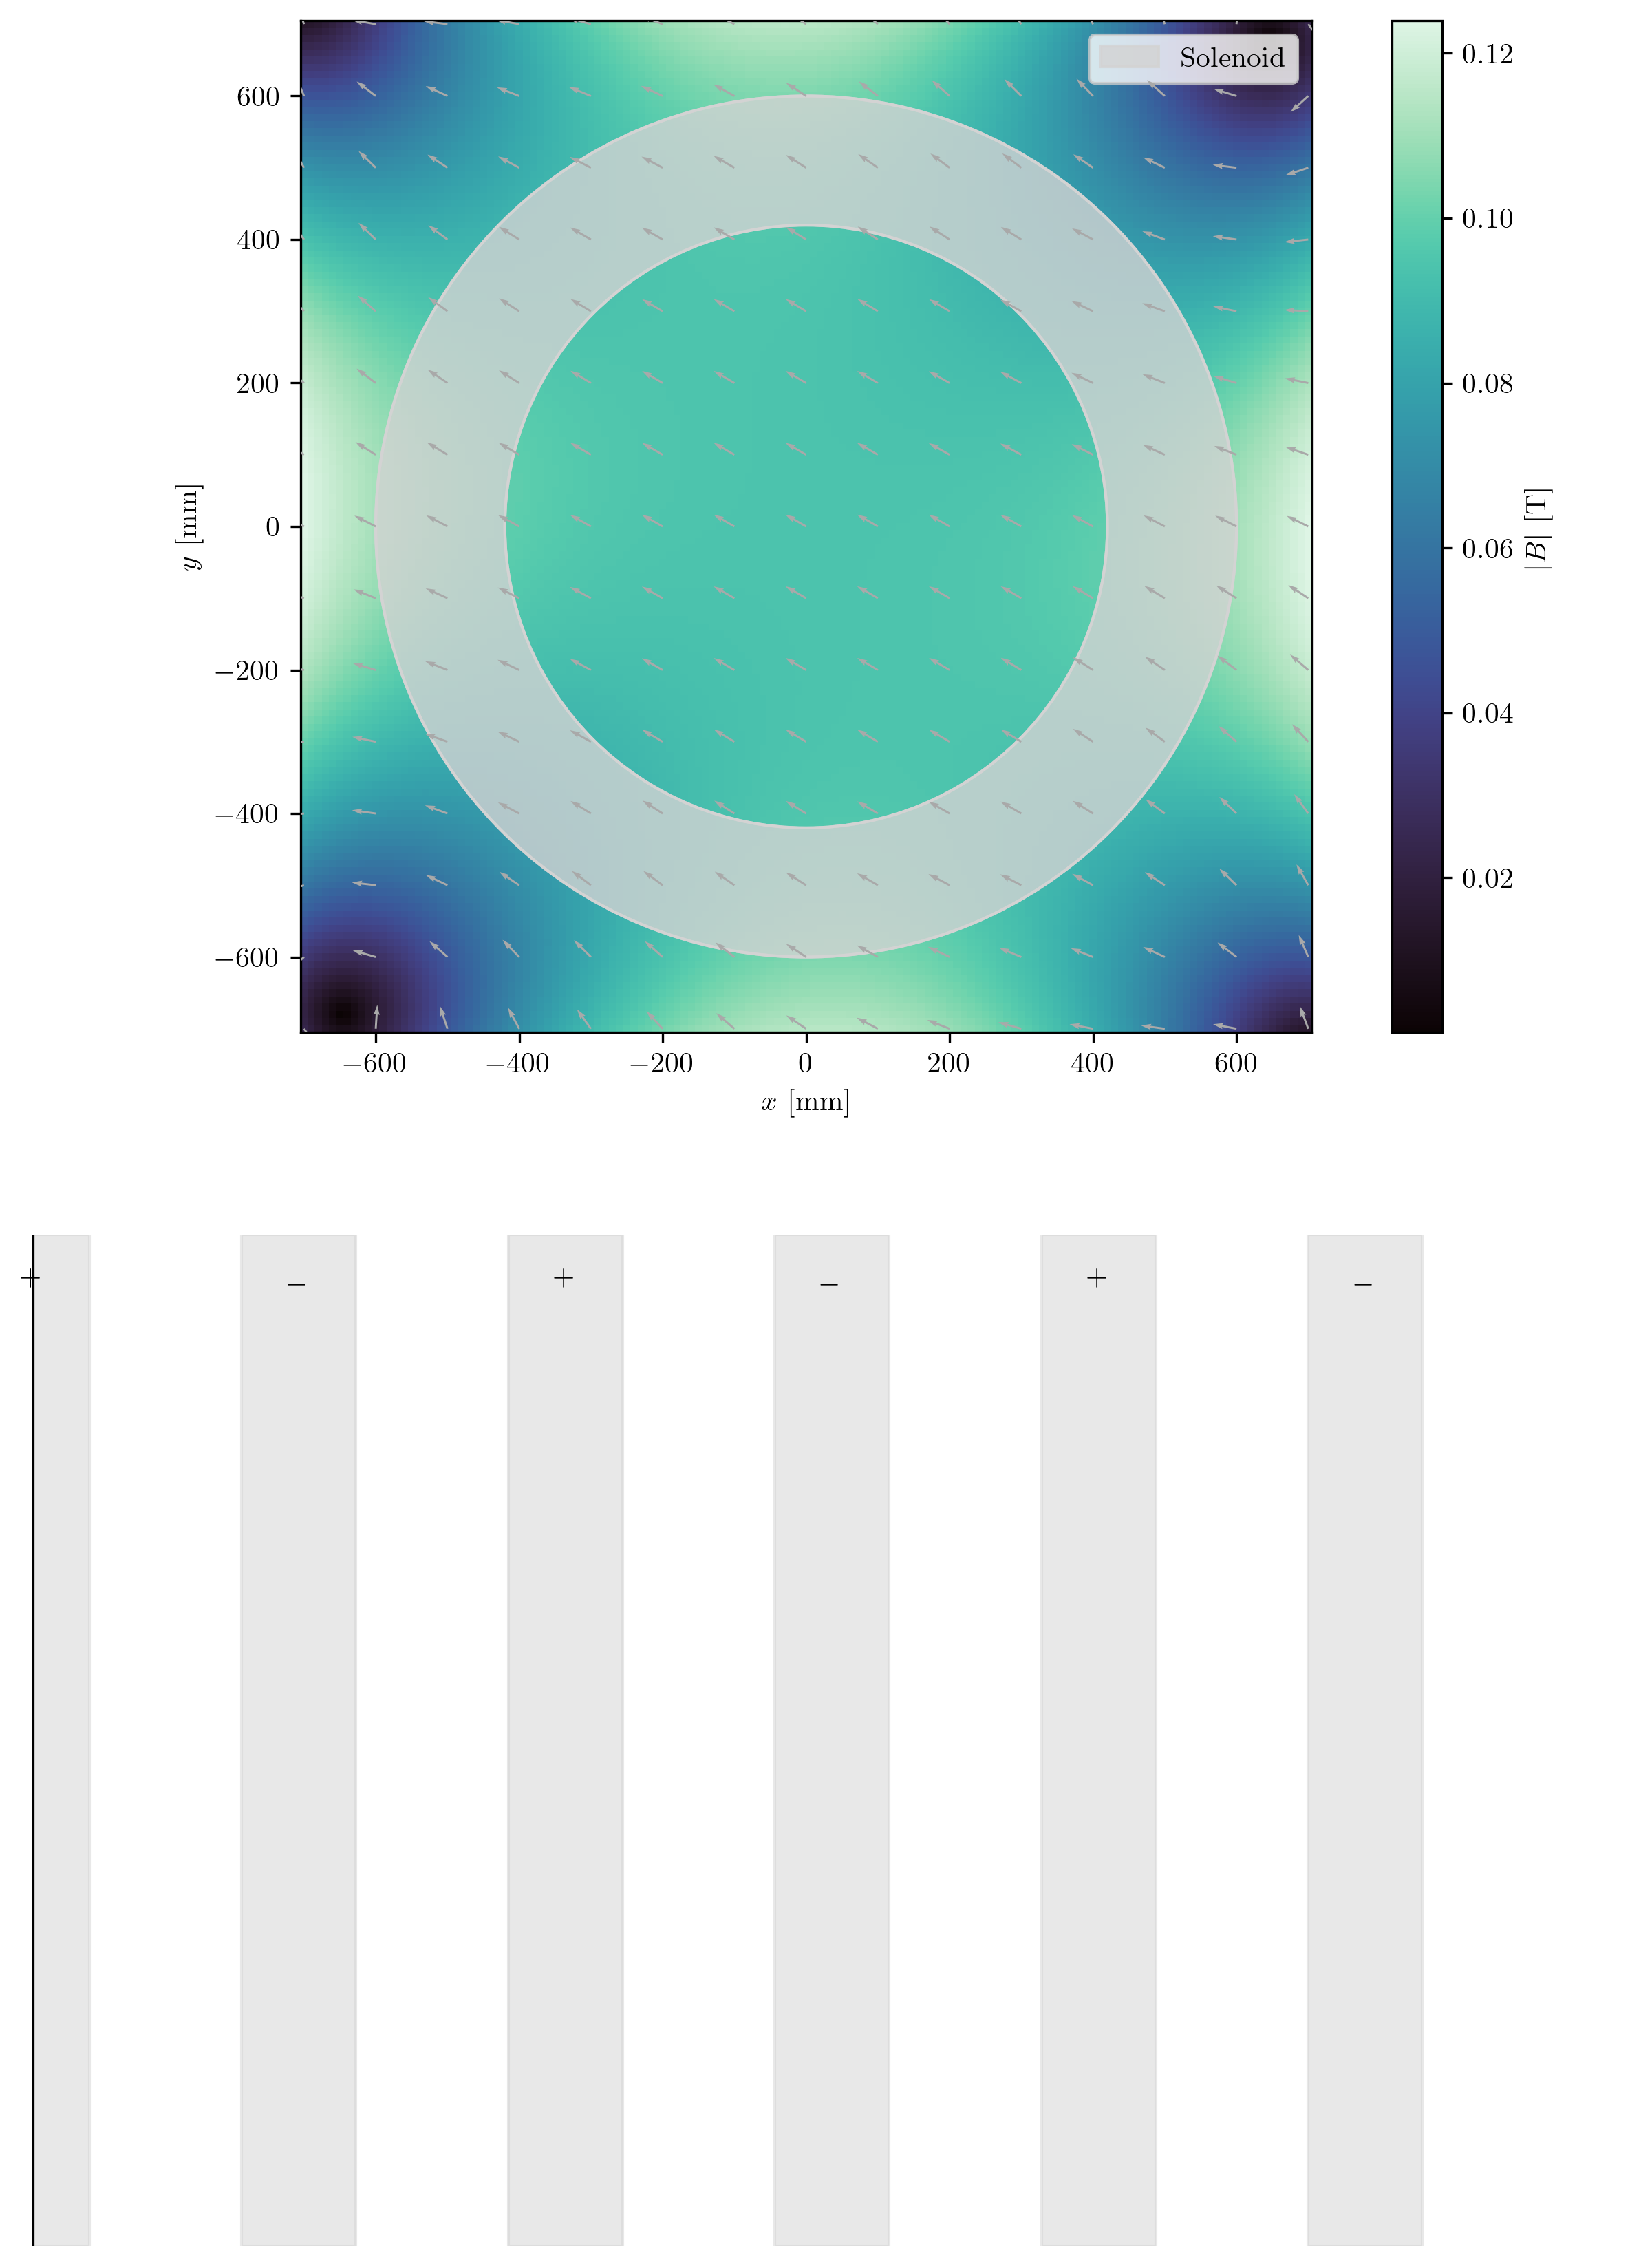

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(10,14))
ax, ax2 = axs[0], axs[1]

arrayy = [0, 0]
ax2.set_xlim(0, 4200)
plotLattice(ax2, label=True)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_frame_on(False)
vline = ax2.axvline(x=df['z'].values[0], color='black')

cmap = sns.color_palette('mako', as_cmap=True)
pcm = ax.pcolormesh(X, Y, B_by_z[0], cmap=cmap)
plt.colorbar(pcm, ax=ax, label='$|B|$ [T]') # may require some scaling?

ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
plotSolenoid(ax, color='lightgray')
ax.set_aspect('equal')

quiver_plot = None

step = 10

def animate(frame):
    global quiver_plot

    z_val = df['z'].values[frame]
    vline.set_xdata([z_val])

    Bx_grid = Bx_by_z[frame]
    By_grid = By_by_z[frame]
    B_grid = B_by_z[frame]

    X_ds = X[::step, ::step]
    Y_ds = Y[::step, ::step]
    Bx_ds = Bx_grid[::step, ::step]
    By_ds = By_grid[::step, ::step]
    B_ds = B_grid[::step, ::step]

    Bx_norm = Bx_ds / (B_ds + 1e-12)
    By_norm = By_ds / (B_ds + 1e-12)

    pcm.set_array(B_grid.ravel())

    if quiver_plot:
        quiver_plot.remove()

    quiver_plot = ax.quiver(
        X_ds, Y_ds, Bx_norm, By_norm,
        color='darkgray',
        angles="xy", scale_units="xy", scale=0.03,
        width=0.002, zorder=10
    )

    return [vline, quiver_plot]

animation = FuncAnimation(fig, animate, frames=len(df['z'].values), interval=100, blit=False, repeat=False)
animation.save(ani_dir+'multipole_expansion_quiver.gif', writer='pillow')

## Isolate contributions from solenoid rotations

In [13]:
data_norot = readFieldMapData(file_norot)

data_diff = data.copy()
data_diff['Bx'] = data['Bx'] - data_norot['Bx']
data_diff['By'] = data['By'] - data_norot['By']
data_diff['Bz'] = data['Bz'] - data_norot['Bz']
data_diff['Br'] = data['Br'] - data_norot['Br']

In [14]:
df_diff, df_diff2 = func(data_diff, X, Y)

#### Magnitudes:

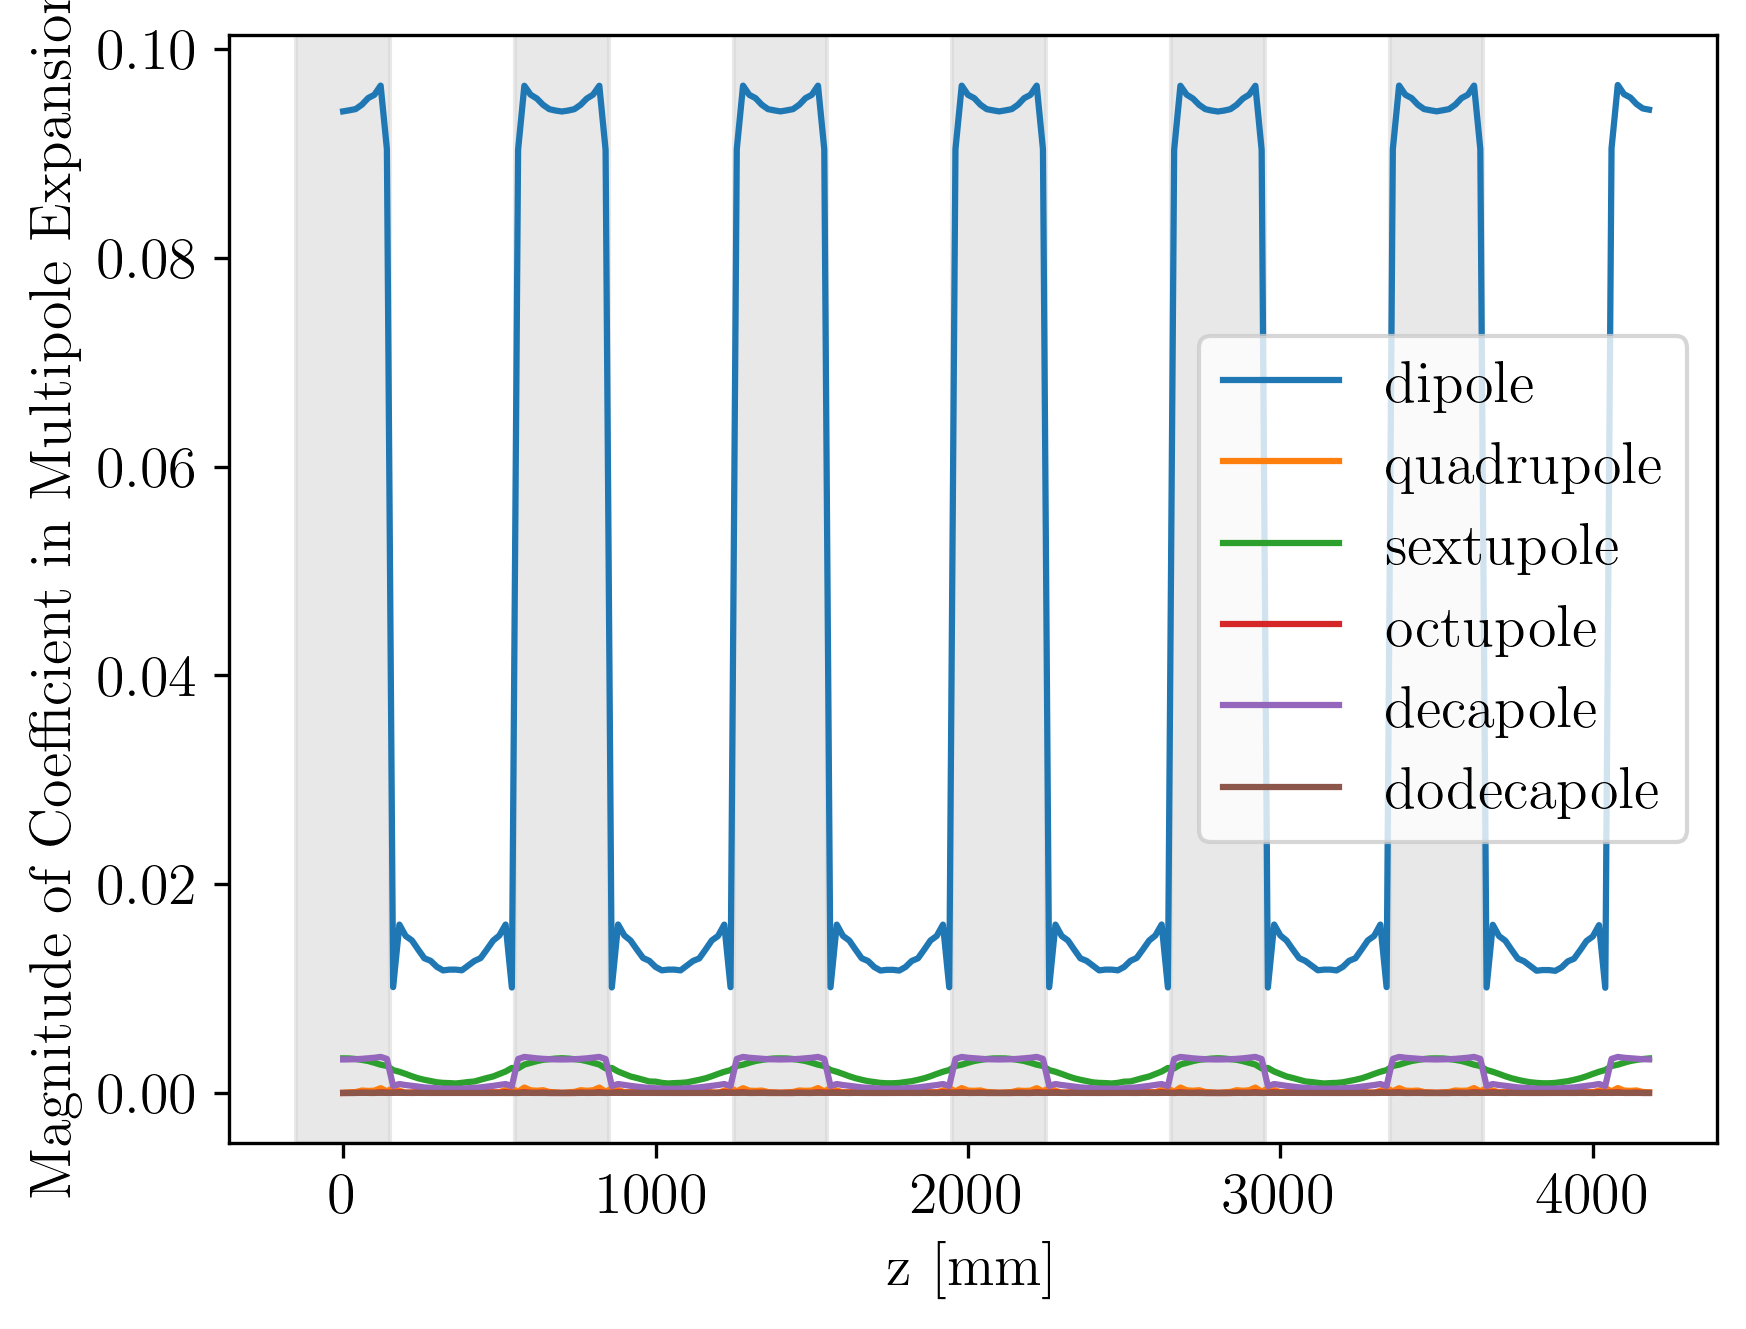

In [15]:
fig, ax = plt.subplots()
plt.plot(df_diff['z'], df_diff['n=1'], label='dipole')
plt.plot(df_diff['z'], df_diff['n=2'], label='quadrupole')
plt.plot(df_diff['z'], df_diff['n=3'], label='sextupole')
plt.plot(df_diff['z'], df_diff['n=4'], label='octupole')
plt.plot(df_diff['z'], df_diff['n=5'], label='decapole')
plt.plot(df_diff['z'], df_diff['n=6'], label='dodecapole')
plt.legend()
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

#### Phases:

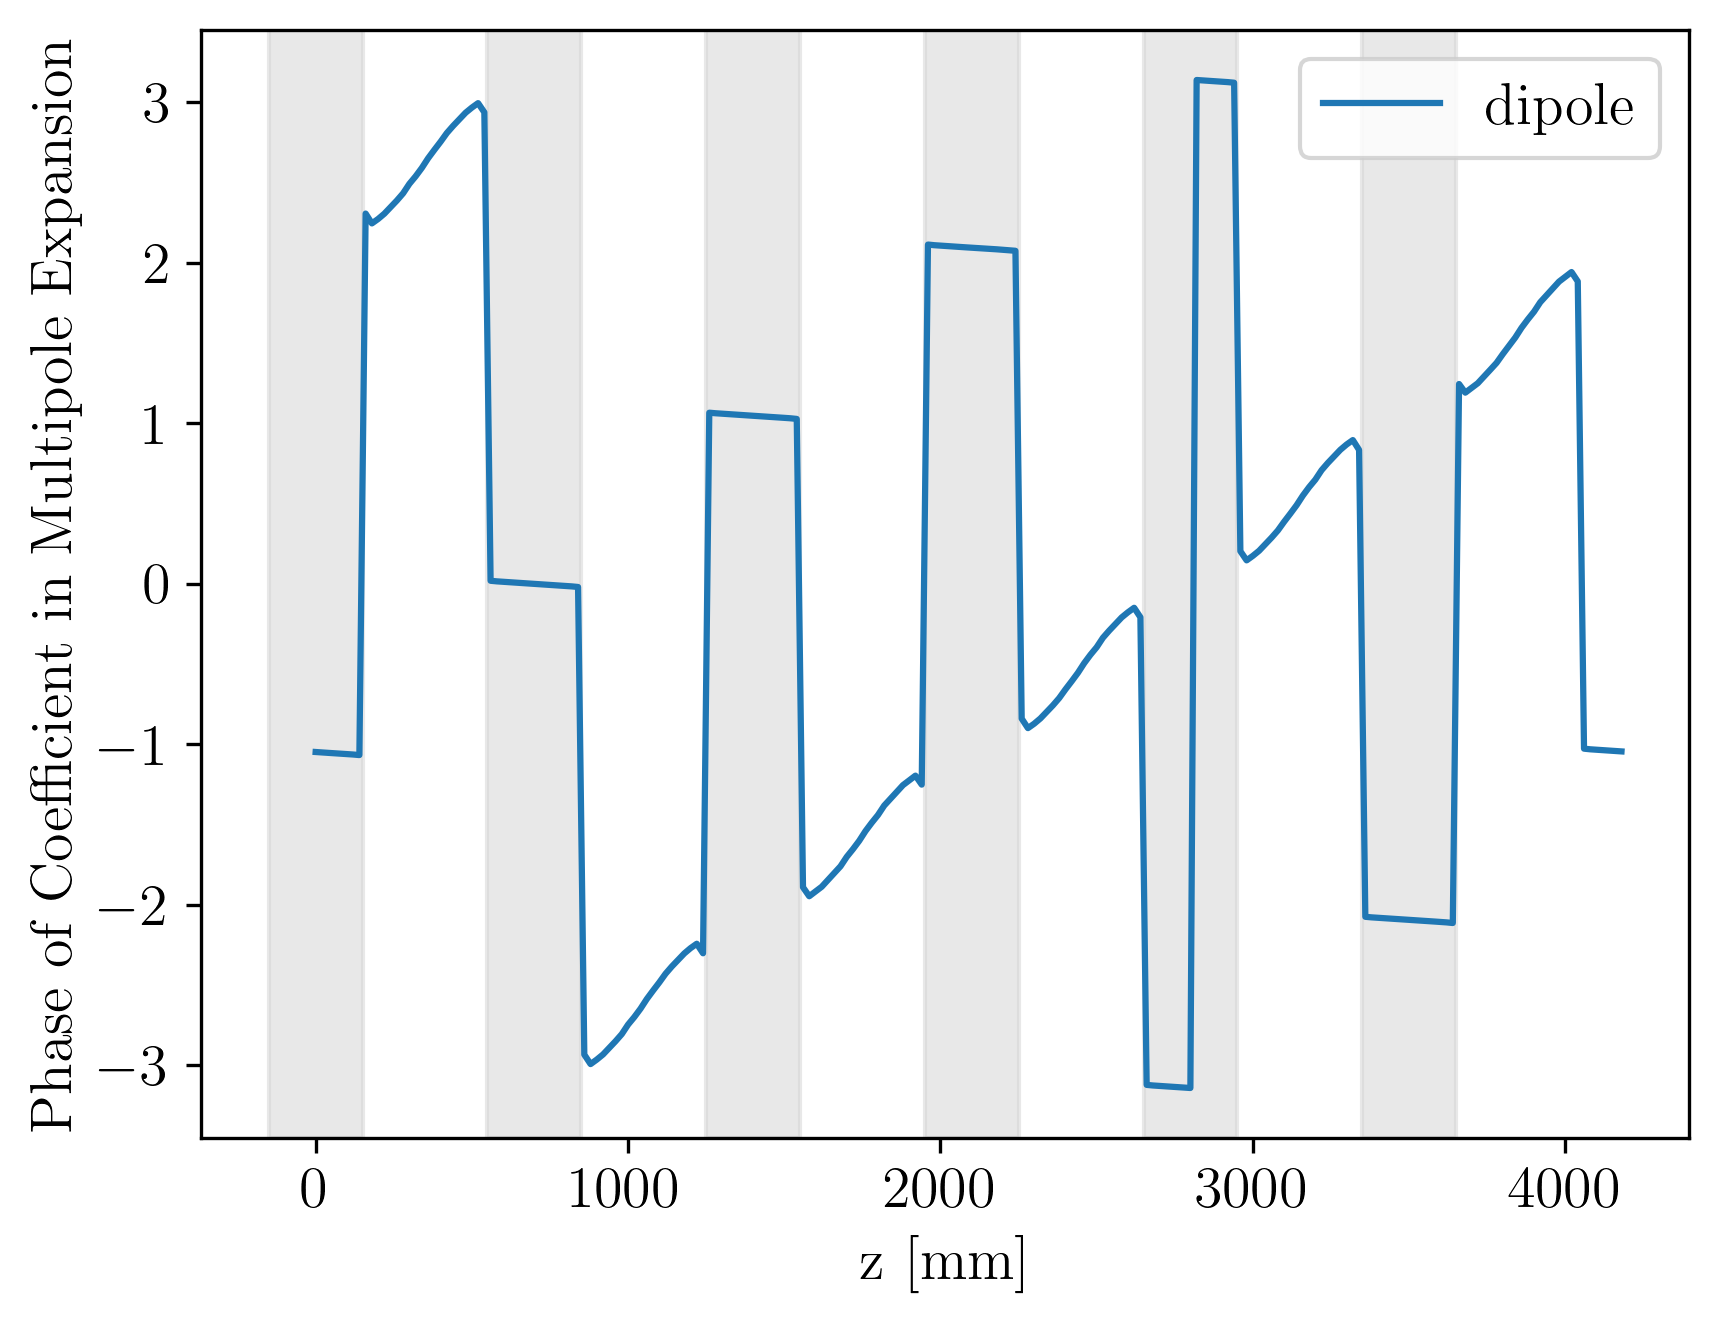

In [16]:
fig, ax = plt.subplots()
plt.plot(df_diff2['z'], df_diff2['n=1'], label='dipole', color='tab:blue')
plt.legend()
plt.xlabel('z [mm]')
plt.ylabel('Phase of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

In [17]:
Bx_by_z = []
By_by_z = []
B_by_z = []
for z in df_diff['z'].values:

        coeff_list_mag = df_diff.loc[np.where(df_diff['z']==z)[0]].values[0][1:]
        coeff_list_phase = df_diff2.loc[np.where(df_diff2['z']==z)[0]].values[0][1:]

        Bx_slice, By_slice = computeField(x, y, coeff_list_mag, coeff_list_phase)
        Bx_by_z.append(Bx_slice)
        By_by_z.append(By_slice)
        theta = np.arctan2(By_slice, Bx_slice)
        B = Bx_slice*np.cos(theta) + By_slice*np.sin(theta)
        B_by_z.append(B)

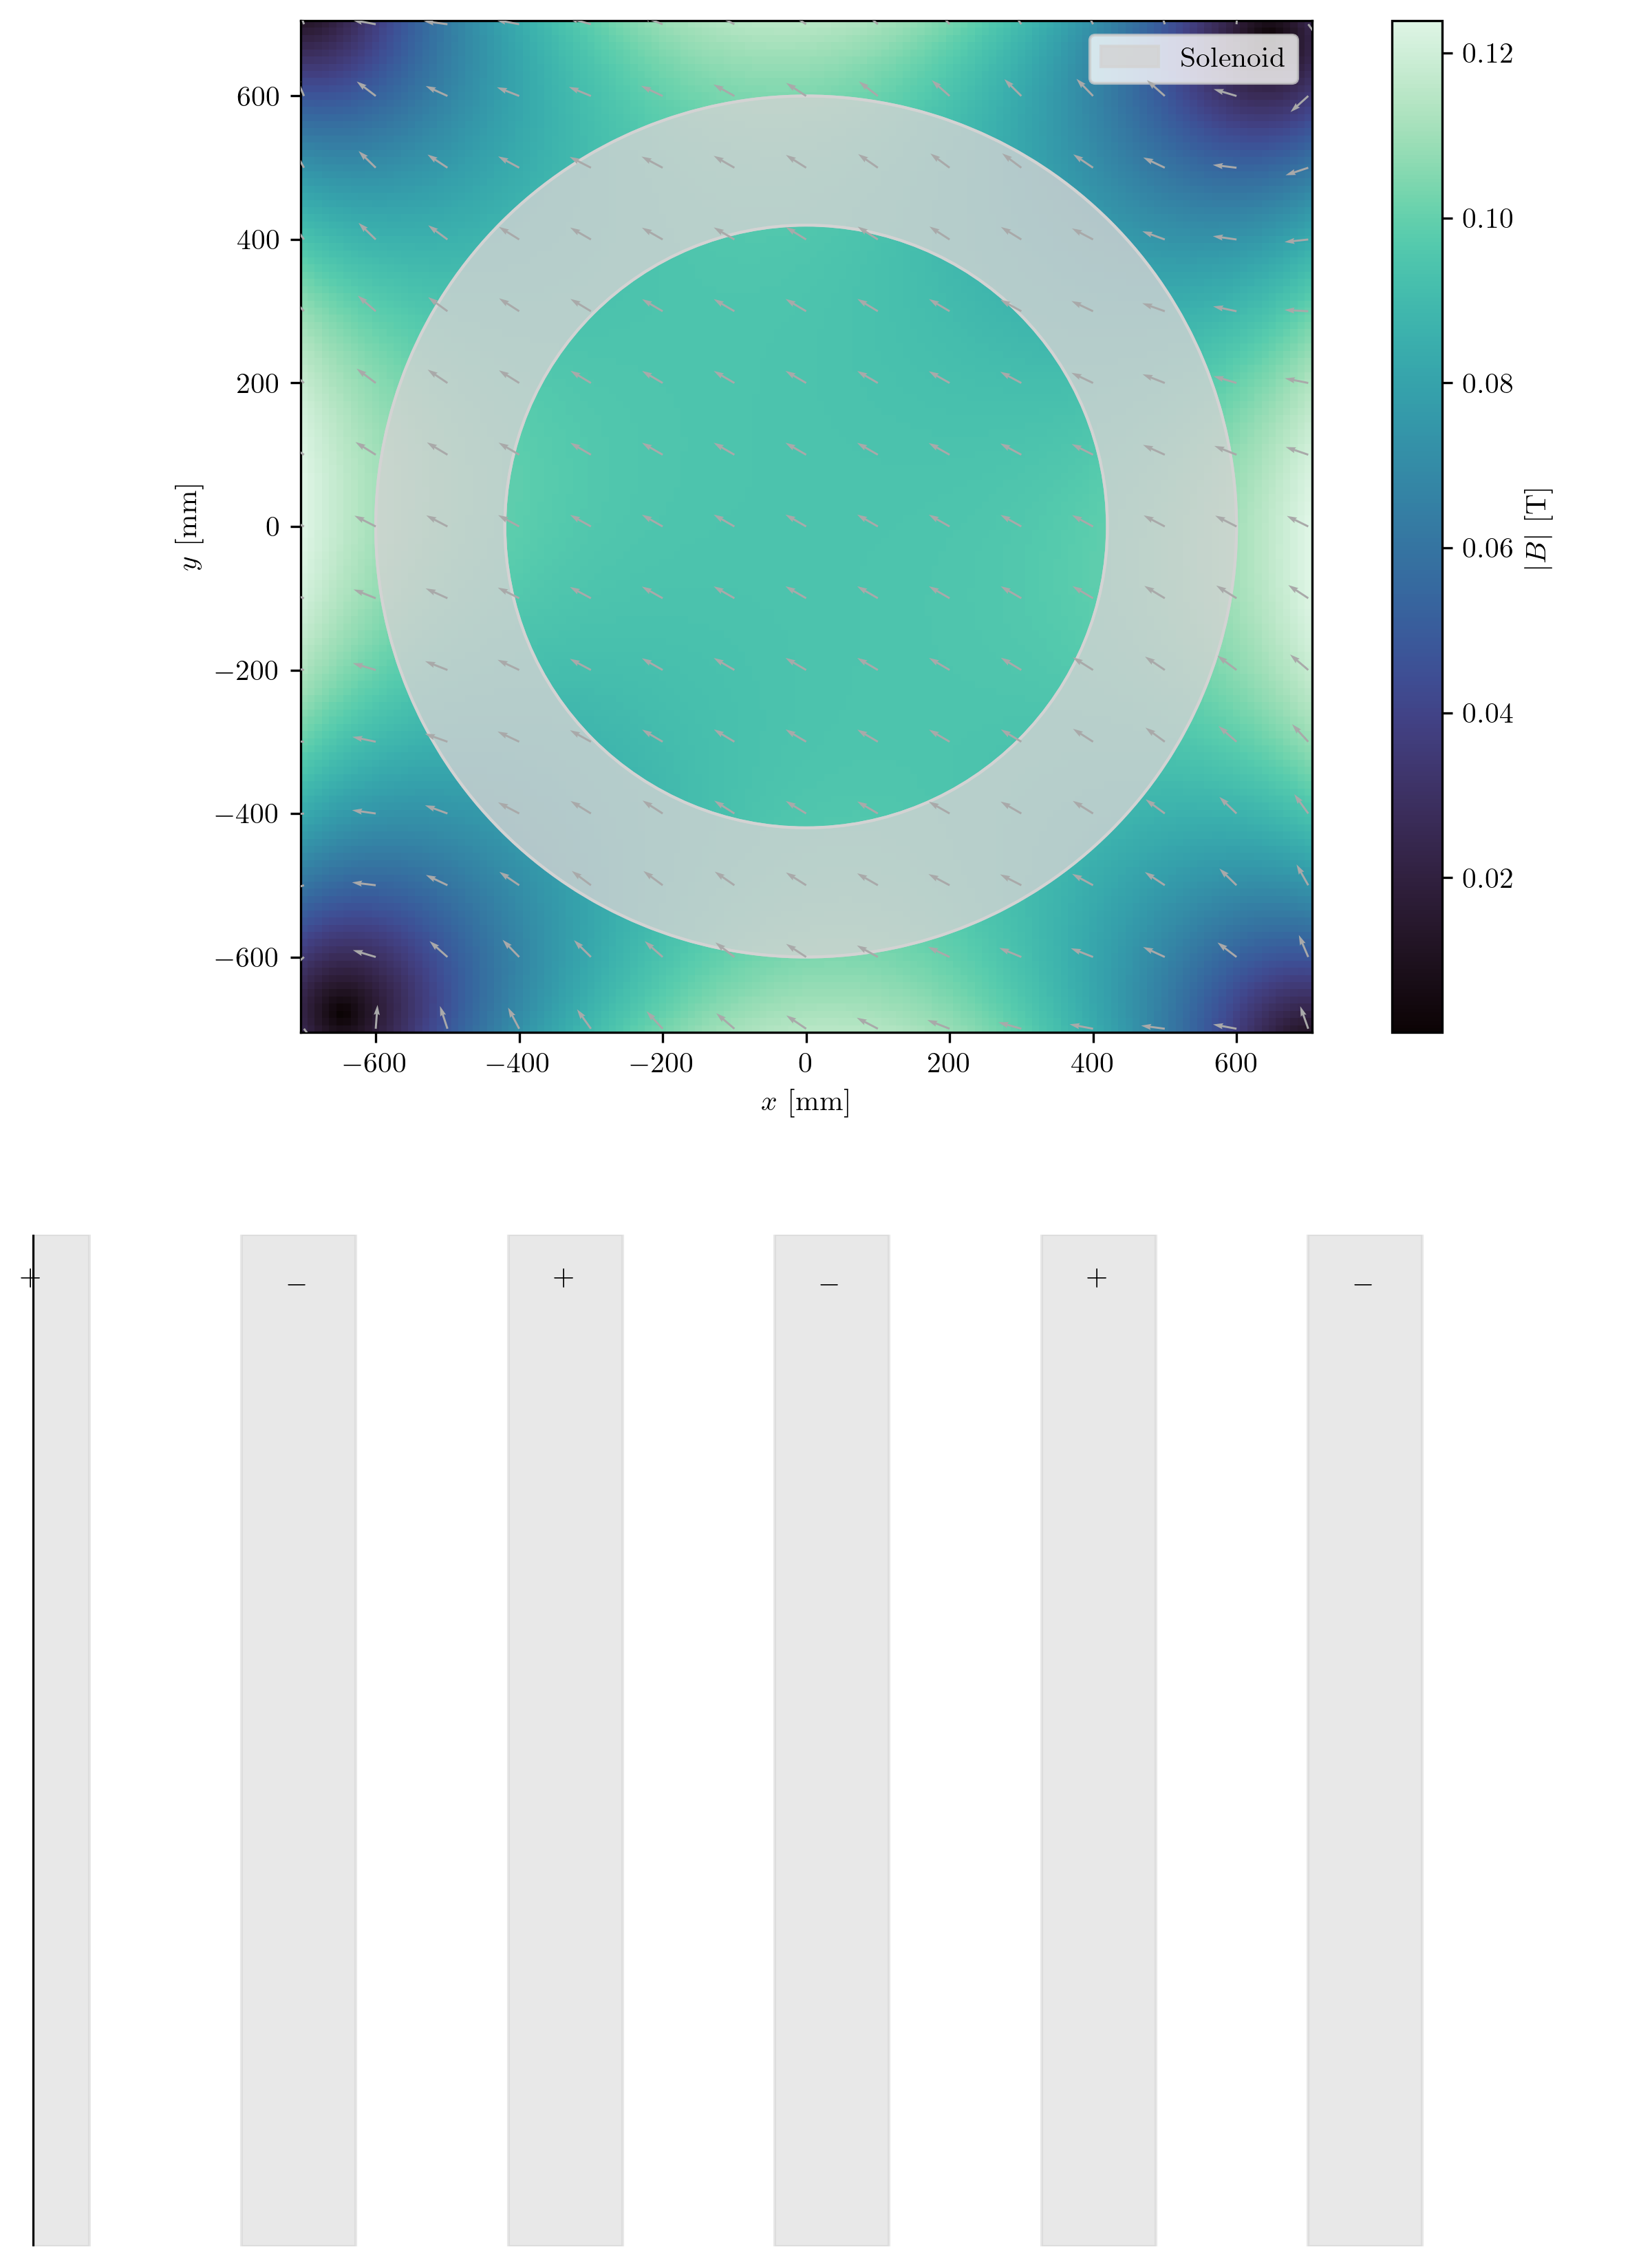

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10,14))
ax, ax2 = axs[0], axs[1]

arrayy = [0, 0]
ax2.set_xlim(0, 4200)
plotLattice(ax2, label=True)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_frame_on(False)
vline = ax2.axvline(x=df['z'].values[0], color='black')

cmap = sns.color_palette('mako', as_cmap=True)
pcm = ax.pcolormesh(X, Y, B_by_z[0], cmap=cmap)
plt.colorbar(pcm, ax=ax, label='$|B|$ [T]') # may require some scaling?

ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
plotSolenoid(ax, color='lightgray')
ax.set_aspect('equal')

quiver_plot = None

step = 10

def animate(frame):
    global quiver_plot

    z_val = df['z'].values[frame]
    vline.set_xdata([z_val])

    Bx_grid = Bx_by_z[frame]
    By_grid = By_by_z[frame]
    B_grid = B_by_z[frame]

    X_ds = X[::step, ::step]
    Y_ds = Y[::step, ::step]
    Bx_ds = Bx_grid[::step, ::step]
    By_ds = By_grid[::step, ::step]
    B_ds = B_grid[::step, ::step]

    Bx_norm = Bx_ds / (B_ds + 1e-12)
    By_norm = By_ds / (B_ds + 1e-12)

    pcm.set_array(B_grid.ravel())

    if quiver_plot:
        quiver_plot.remove()

    quiver_plot = ax.quiver(
        X_ds, Y_ds, Bx_norm, By_norm,
        color='darkgray',
        angles="xy", scale_units="xy", scale=0.03,
        width=0.002, zorder=10
    )

    return [vline, quiver_plot]

animation = FuncAnimation(fig, animate, frames=len(df['z'].values), interval=100, blit=False, repeat=False)
animation.save(ani_dir+'multipole_expansion_quiver_diff.gif', writer='pillow')

#### Limit to region within the solenoid

In [18]:
data_diff['r'] = np.sqrt(data_diff['x']**2 + data_diff['y']**2)

lim = 400
data_diff_lim = data_diff[data_diff['r'] < lim]

In [19]:
x = np.unique(data_diff_lim['x'].values)
y = np.unique(data_diff_lim['y'].values)
X, Y = np.meshgrid(x, y)
Xlim, Ylim = X.copy(), Y.copy()

mask = X**2 + Y**2 < lim**2

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i][j] == False:
            Xlim[i][j] = np.nan
            Ylim[i][j] = np.nan

# Fit over circular region only
df_diff_lim, df_diff_lim2 = func(data_diff_lim, Xlim, Ylim, R_ref=lim)

#### Magnitudes:

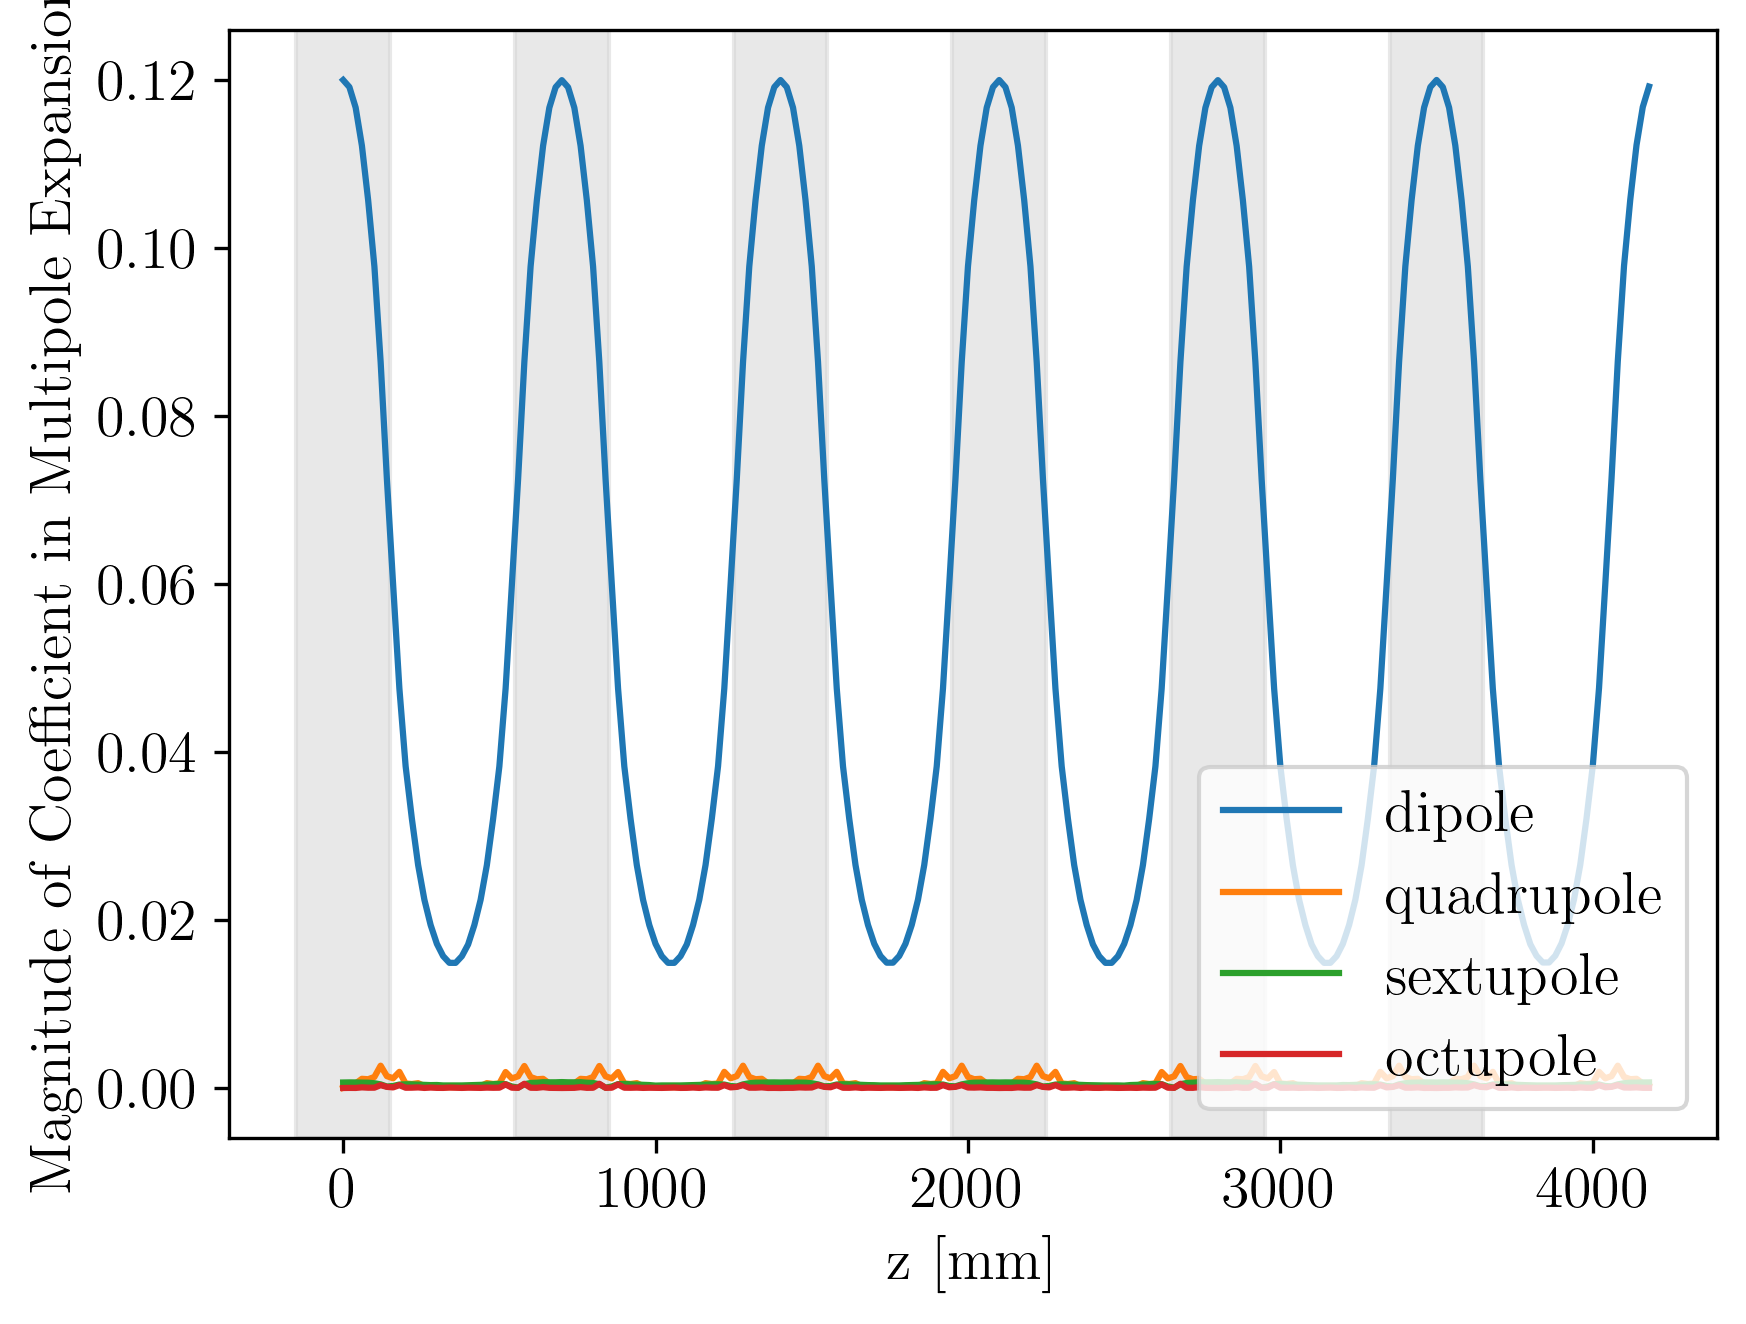

In [20]:
fig, ax = plt.subplots()
plt.plot(df_diff_lim['z'], df_diff_lim['n=1'], label='dipole')
plt.plot(df_diff_lim['z'], df_diff_lim['n=2'], label='quadrupole')
plt.plot(df_diff_lim['z'], df_diff_lim['n=3'], label='sextupole')
plt.plot(df_diff_lim['z'], df_diff_lim['n=4'], label='octupole')
plt.legend(loc='lower right')
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

#### Phases:

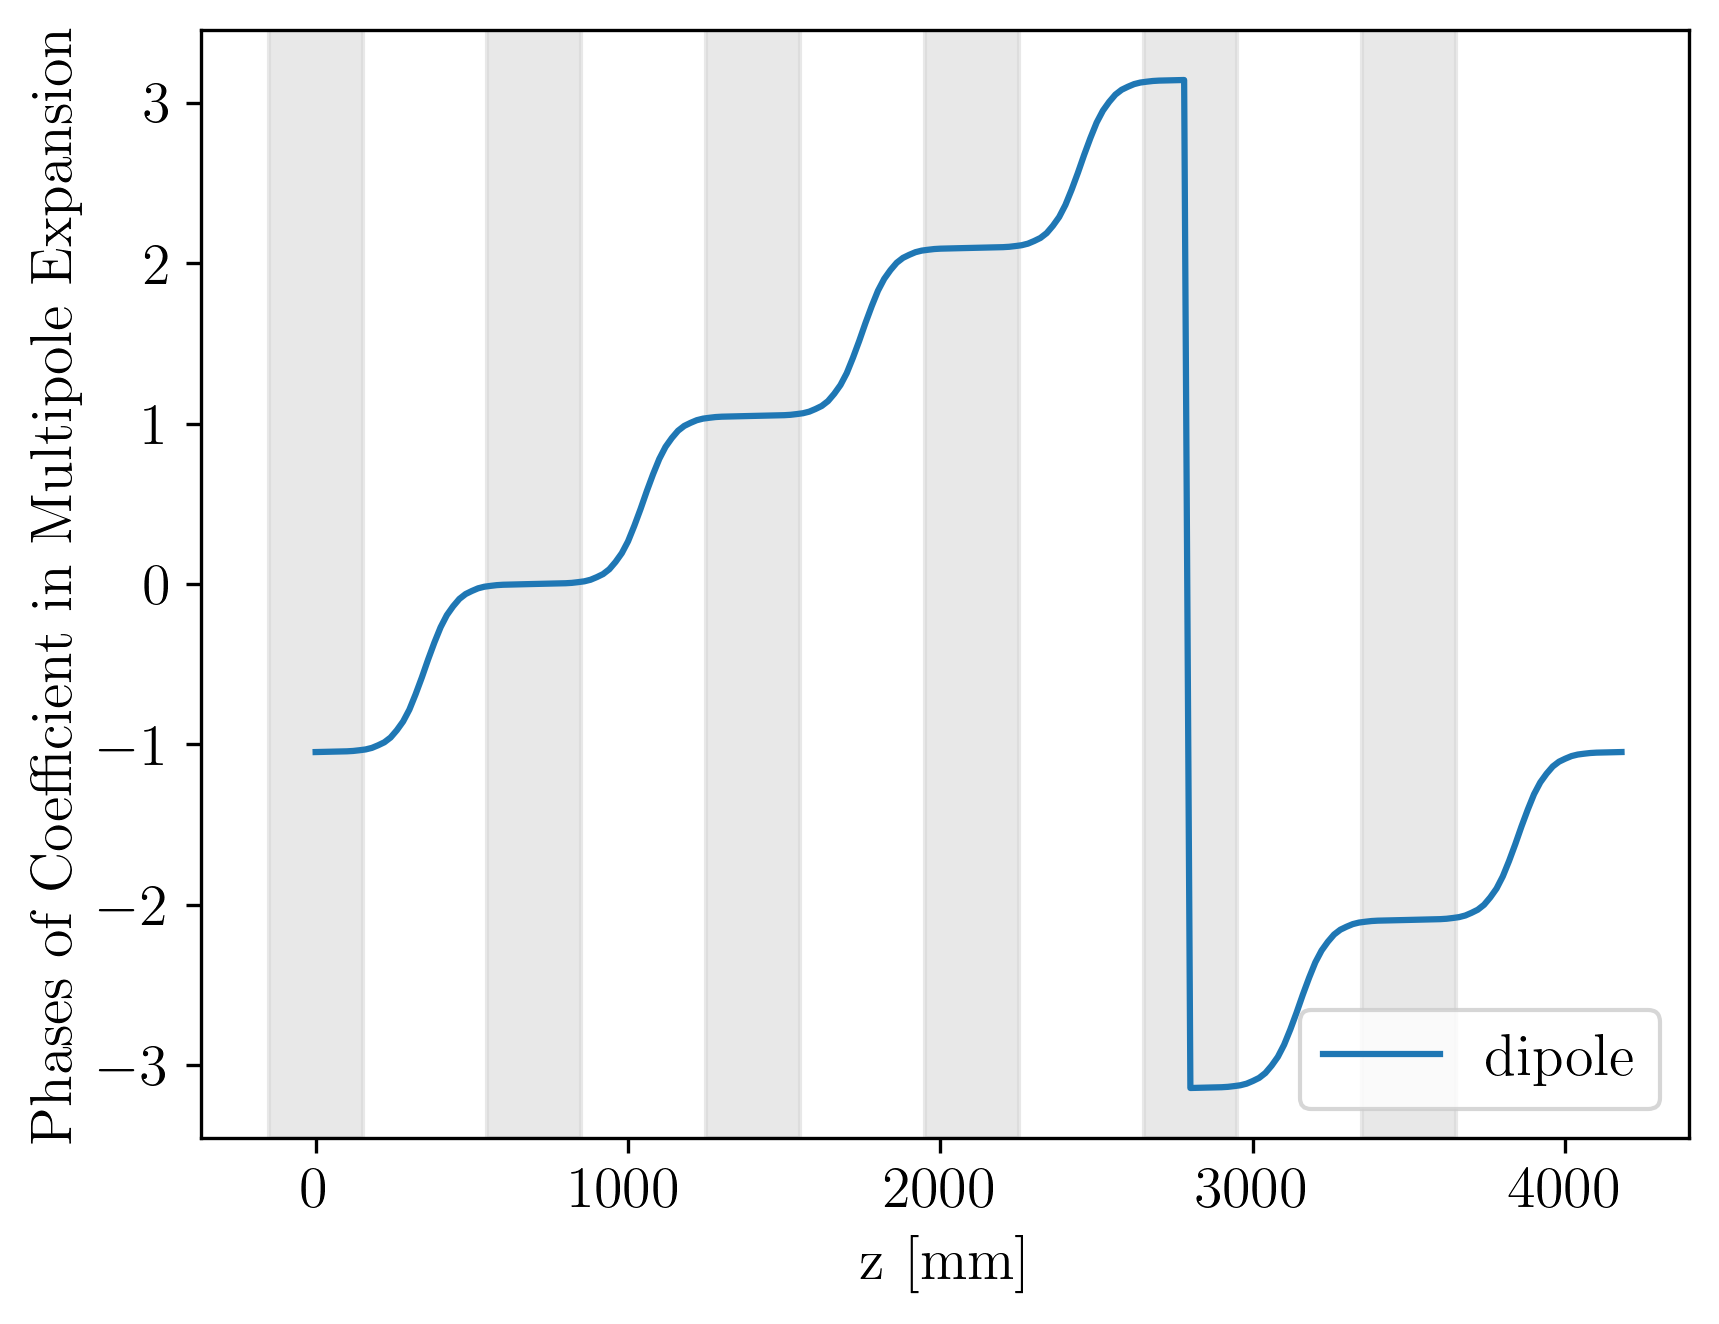

In [21]:
fig, ax = plt.subplots()
plt.plot(df_diff_lim2['z'], df_diff_lim2['n=1'], label='dipole')
plt.legend(loc='lower right')
plt.xlabel('z [mm]')
plt.ylabel('Phases of Coefficient in Multipole Expansion')
plotLattice(ax)
plt.show()

In [22]:
Bx_by_z = []
By_by_z = []
B_by_z = []
for z in df_diff_lim['z'].values:

        coeff_list_mag = df_diff_lim.loc[np.where(df_diff_lim['z']==z)[0]].values[0][1:]
        coeff_list_phase = df_diff_lim2.loc[np.where(df_diff_lim2['z']==z)[0]].values[0][1:]

        Bx_slice, By_slice = computeField(x, y, coeff_list_mag, coeff_list_phase)
        Bx_by_z.append(Bx_slice)
        By_by_z.append(By_slice)
        theta = np.arctan2(By_slice, Bx_slice)
        B = Bx_slice*np.cos(theta) + By_slice*np.sin(theta)
        B_by_z.append(B)

In [23]:
# Map back to circular region after evaluating (to match region in which fit was performed)
for z in range(len(B_by_z)):
    for i in range(B_by_z[i].shape[0]):
        for j in range(B_by_z[i].shape[1]):
            if mask[i][j] == False:
                B_by_z[z][i][j] = np.nan

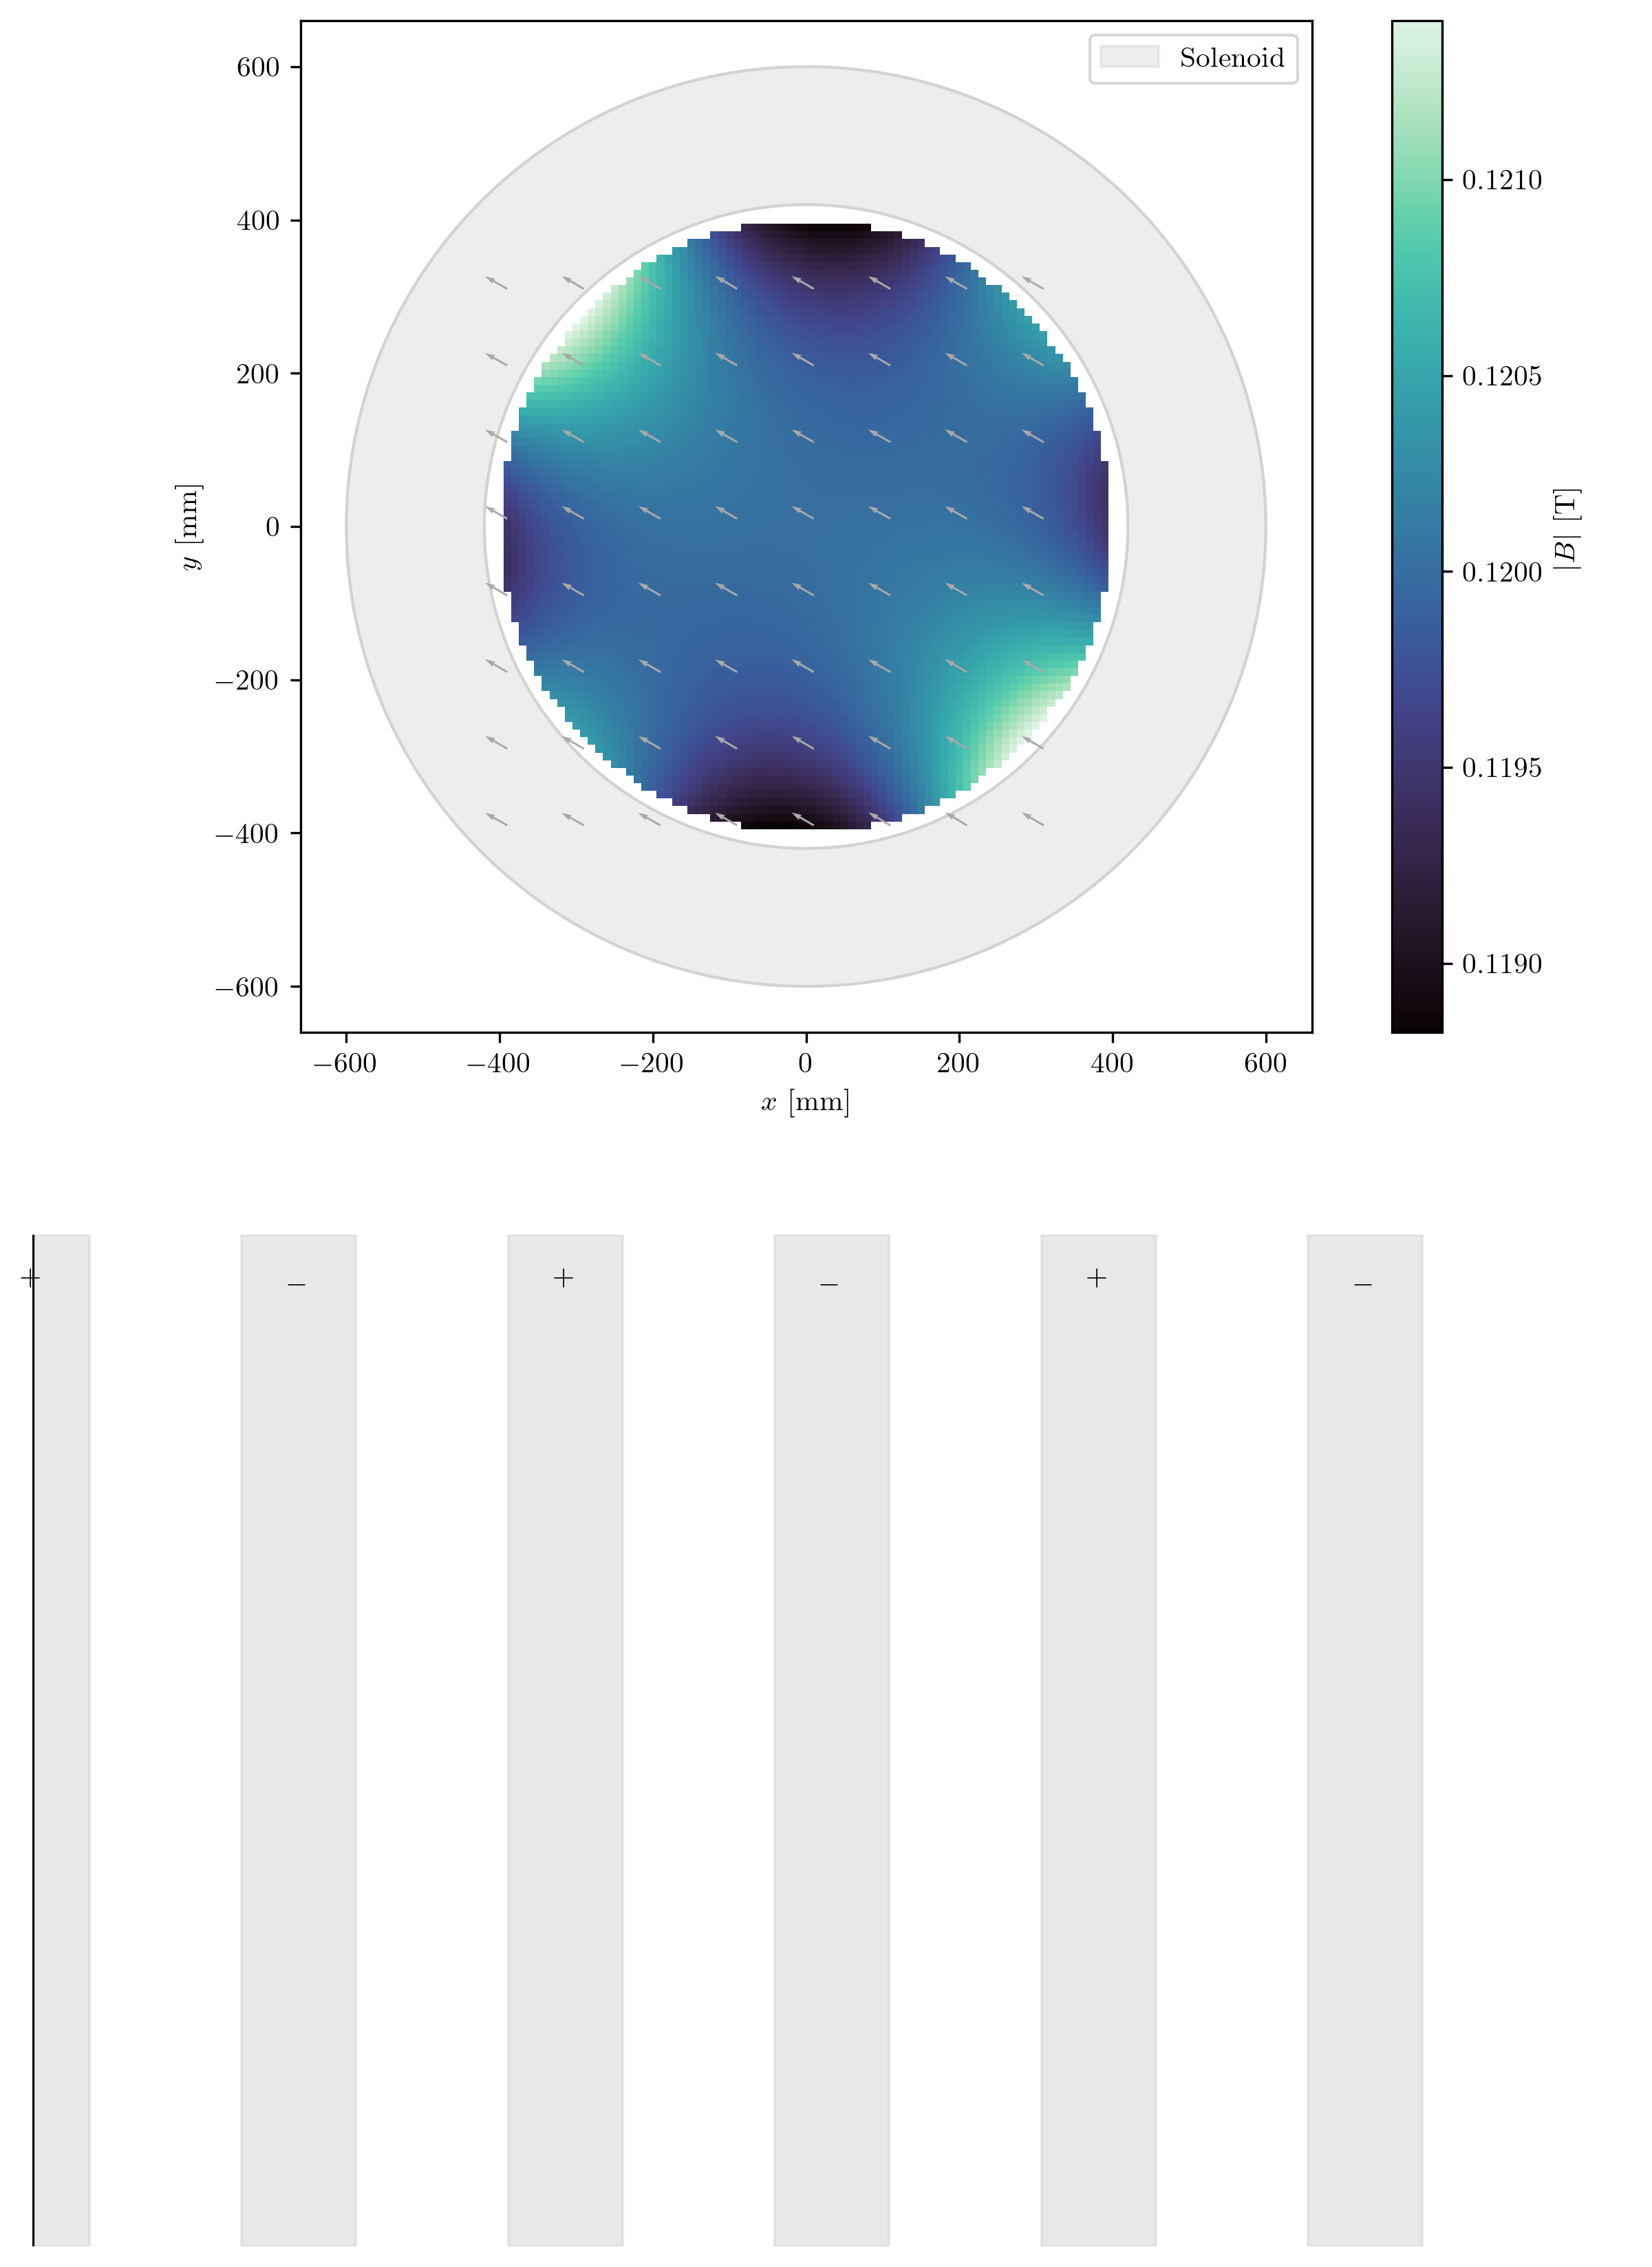

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(10,14))
ax, ax2 = axs[0], axs[1]

arrayy = [0, 0]
ax2.set_xlim(0, 4200)
plotLattice(ax2, label=True)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_frame_on(False)
vline = ax2.axvline(x=df['z'].values[0], color='black')

cmap = sns.color_palette('mako', as_cmap=True)
pcm = ax.pcolormesh(X, Y, B_by_z[0], cmap=cmap)
plt.colorbar(pcm, ax=ax, label='$|B|$ [T]') # may require some scaling?

ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
circle_inner = plt.Circle([0,0], radius=a, fill=False, linestyle='-', color='lightgray')
ax.add_patch(circle_inner)
circle_outer = plt.Circle([0,0], radius=b, fill=False, linestyle='-', color='lightgray')
ax.add_patch(circle_outer)
fill = Wedge(center=(0, 0), r=b, theta1=0, theta2=360, width=b - a, color='lightgray', label='Solenoid', alpha=0.4)
ax.add_patch(fill)
ax.set_aspect('equal')
ax.legend(loc='upper right')

quiver_plot = None

step = 10

def animate(frame):
    global quiver_plot

    z_val = df['z'].values[frame]
    vline.set_xdata([z_val])

    Bx_grid = Bx_by_z[frame]
    By_grid = By_by_z[frame]
    B_grid = B_by_z[frame]

    X_ds = X[::step, ::step]
    Y_ds = Y[::step, ::step]
    Bx_ds = Bx_grid[::step, ::step]
    By_ds = By_grid[::step, ::step]

    magnitude = np.sqrt(Bx_ds**2 + By_ds**2)
    Bx_norm = Bx_ds / (magnitude + 1e-12)
    By_norm = By_ds / (magnitude + 1e-12)

    pcm.set_array(B_grid.ravel())

    if quiver_plot:
        quiver_plot.remove()

    quiver_plot = ax.quiver(
        X_ds, Y_ds, Bx_norm, By_norm,
        color='darkgray',
        angles="xy", scale_units="xy", scale=0.03,
        width=0.002, zorder=10
    )

    return [vline, quiver_plot]

animation = FuncAnimation(fig, animate, frames=len(df['z'].values), interval=100, blit=False, repeat=False)
animation.save(ani_dir+'multipole_expansion_quiver_diff_lim.gif', writer='pillow')

#### Fit to find analytic expression for magnitude via FFT:

In [24]:
# Magnitudes of dipole coefficients:
c = df_diff_lim['n=1'].values
z = df_diff_lim['z'].values

B(z) = 0.122*sin(2π*0.000*z+0.000) + 0.055*sin(2π*0.001*z+0.000) + 0.008*sin(2π*0.003*z+0.000) + 0.002*sin(2π*0.004*z+3.141) + 0.002*sin(2π*0.006*z+3.142)


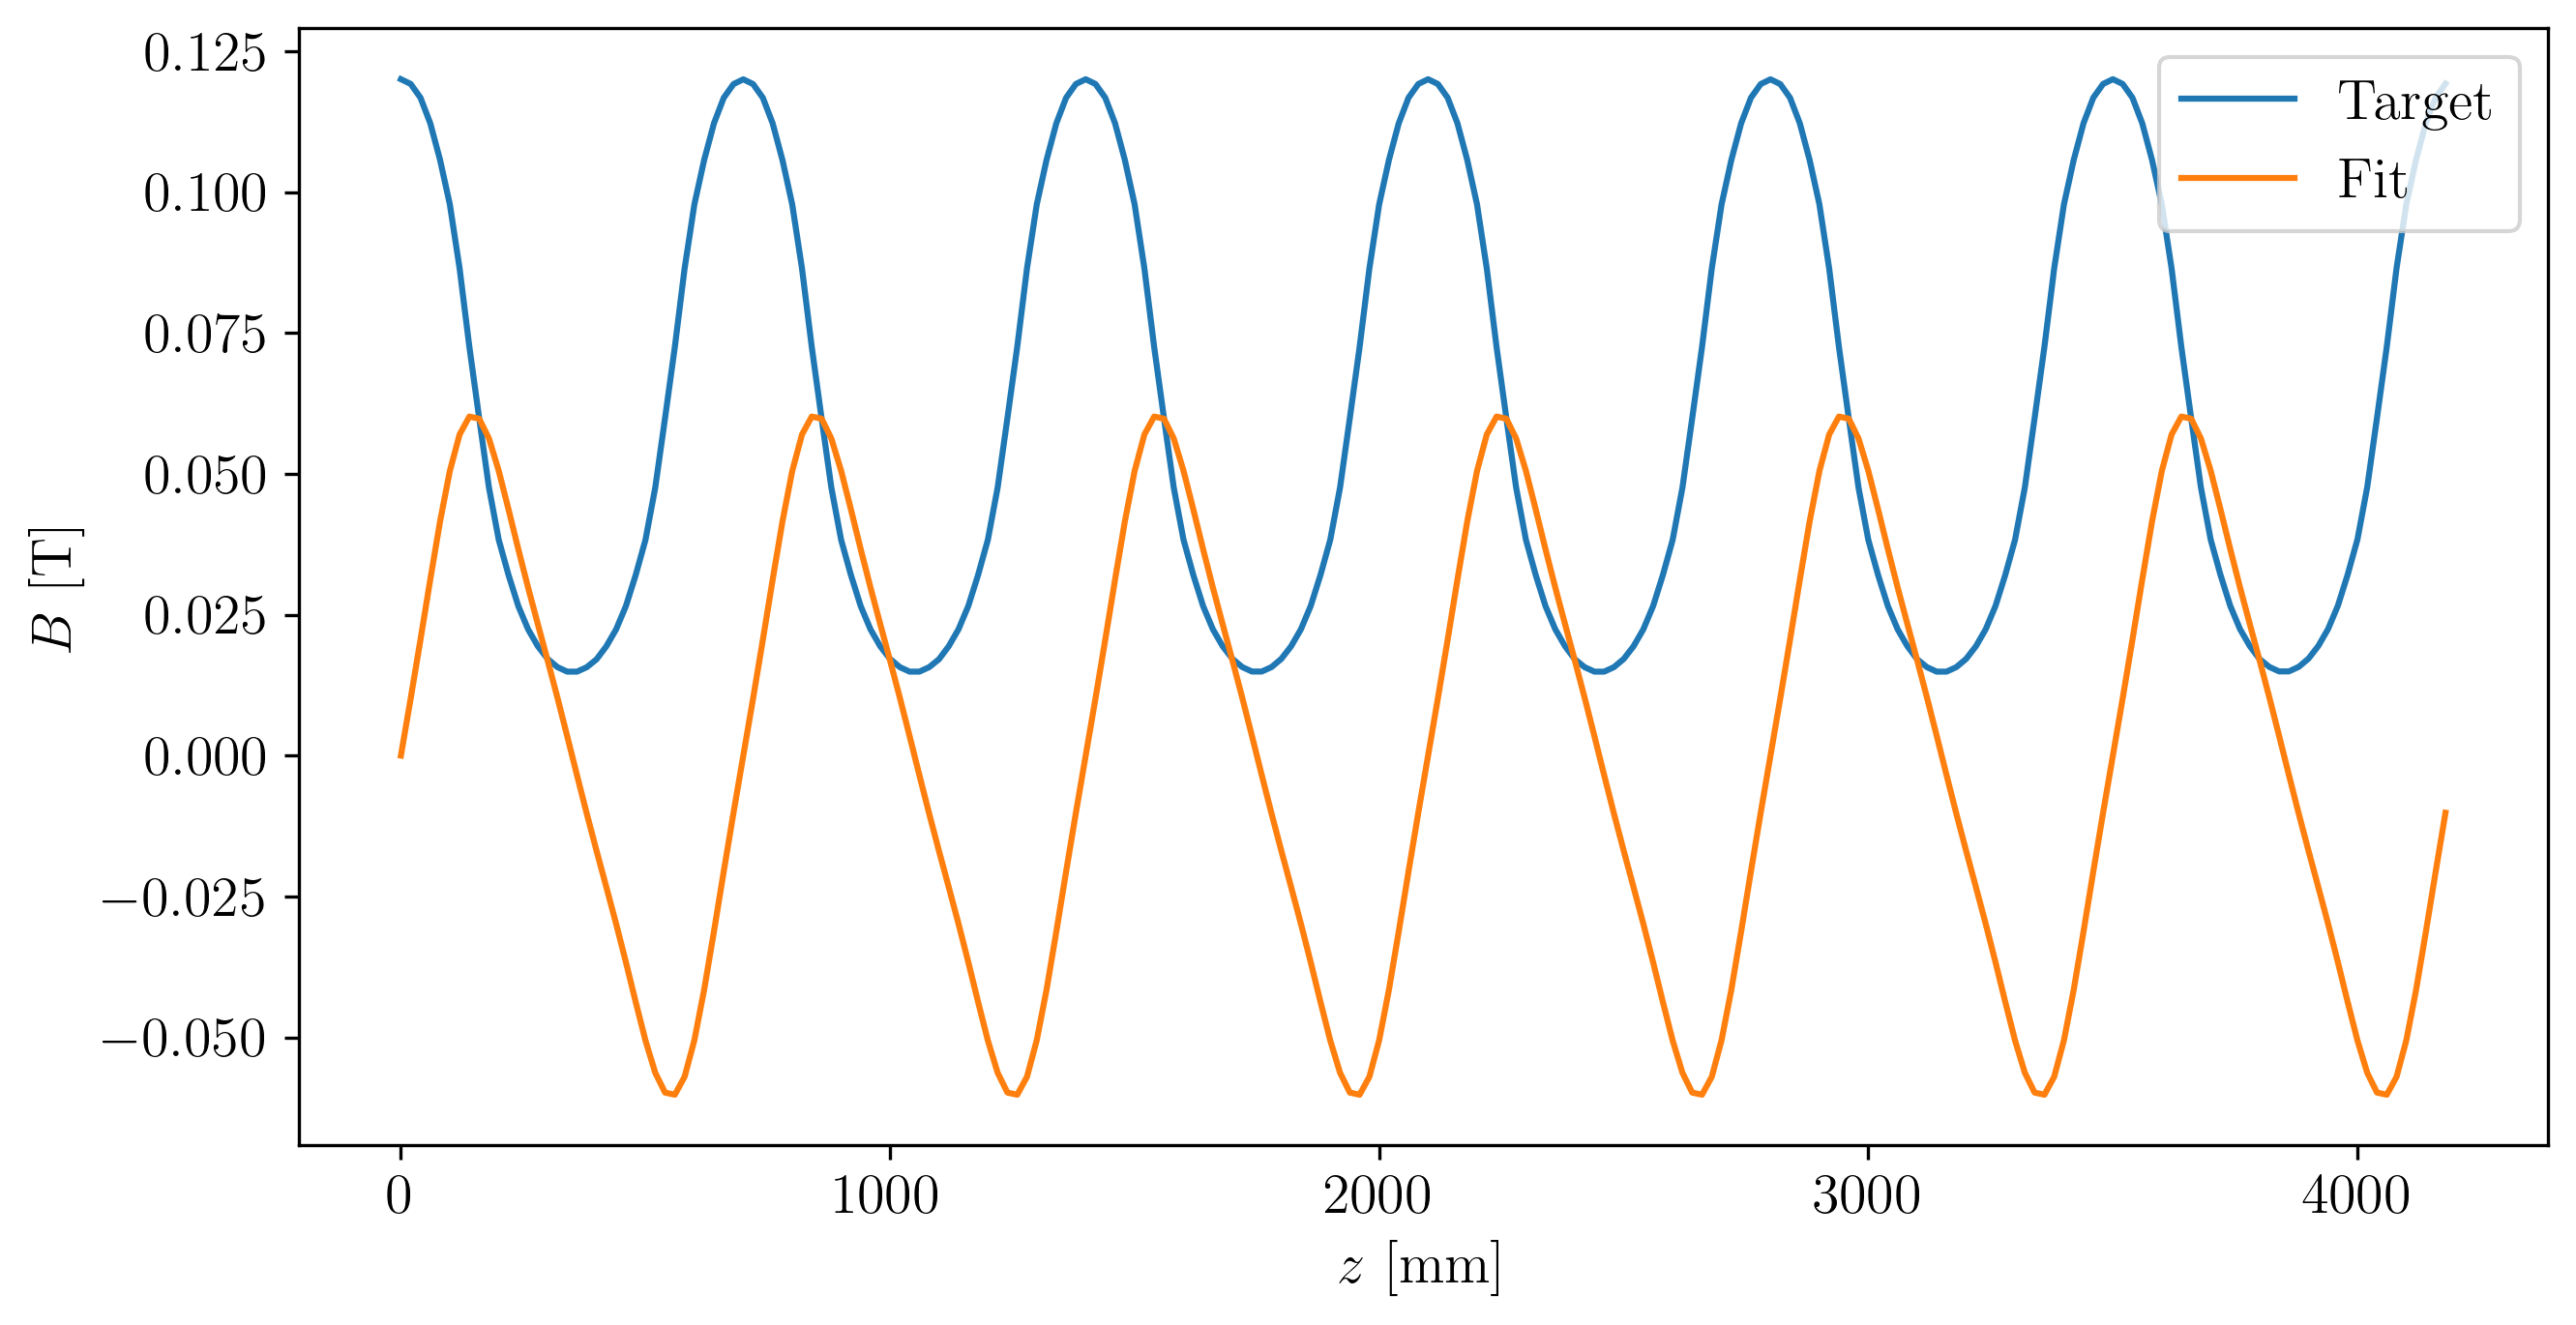

In [25]:
# FFT:
N = len(z)
dz = z[1]-z[0]
freqs = np.fft.fftfreq(N, d=dz)
fft_vals = np.fft.fft(c)

amplitudes = 2/N*np.abs(fft_vals[:N//2])
freqs_pos = freqs[:N//2]

# Number of sine terms to keep:
top_n = 5

idx_sorted = np.argsort(amplitudes)[::-1]
dominant_freqs = freqs_pos[idx_sorted[:top_n]]

recon = np.zeros_like(c, dtype=float)
analytic_terms = []

for f in dominant_freqs:
    k = np.argmin(np.abs(freqs - f))
    A = 2*np.abs(fft_vals[k]) / N
    phase = np.angle(fft_vals[k])
    recon += A*np.sin(2*np.pi*f*z + phase)
    analytic_terms.append(f"{A:.3f}*sin(2π*{f:.3f}*z+{phase:.3f})")

analytic_form = " + ".join(analytic_terms)
print(f"B(z) = {analytic_form}")

plt.figure(figsize=(10, 5))
plt.plot(z, c, label="Target")
plt.plot(z, recon, label="Fit")
plt.legend(loc='upper right')
plt.ylabel("$B$ [T]")
plt.xlabel("$z$ [mm]")
plt.show()

In [26]:
print(dominant_freqs)
print(amplitudes[idx_sorted[:top_n]])

[0.         0.00142857 0.00285714 0.00428571 0.00571429]
[0.12165879 0.05489556 0.00804793 0.00249592 0.00184357]


B(z) = 0.122*sin(2π*0.000*z+0.000) + 0.055*sin(2π*0.001*z+0.000) + 0.008*sin(2π*0.003*z+0.000) + 0.002*sin(2π*0.004*z+3.141) + 0.002*sin(2π*0.006*z+3.142) + 0.07505787741156027


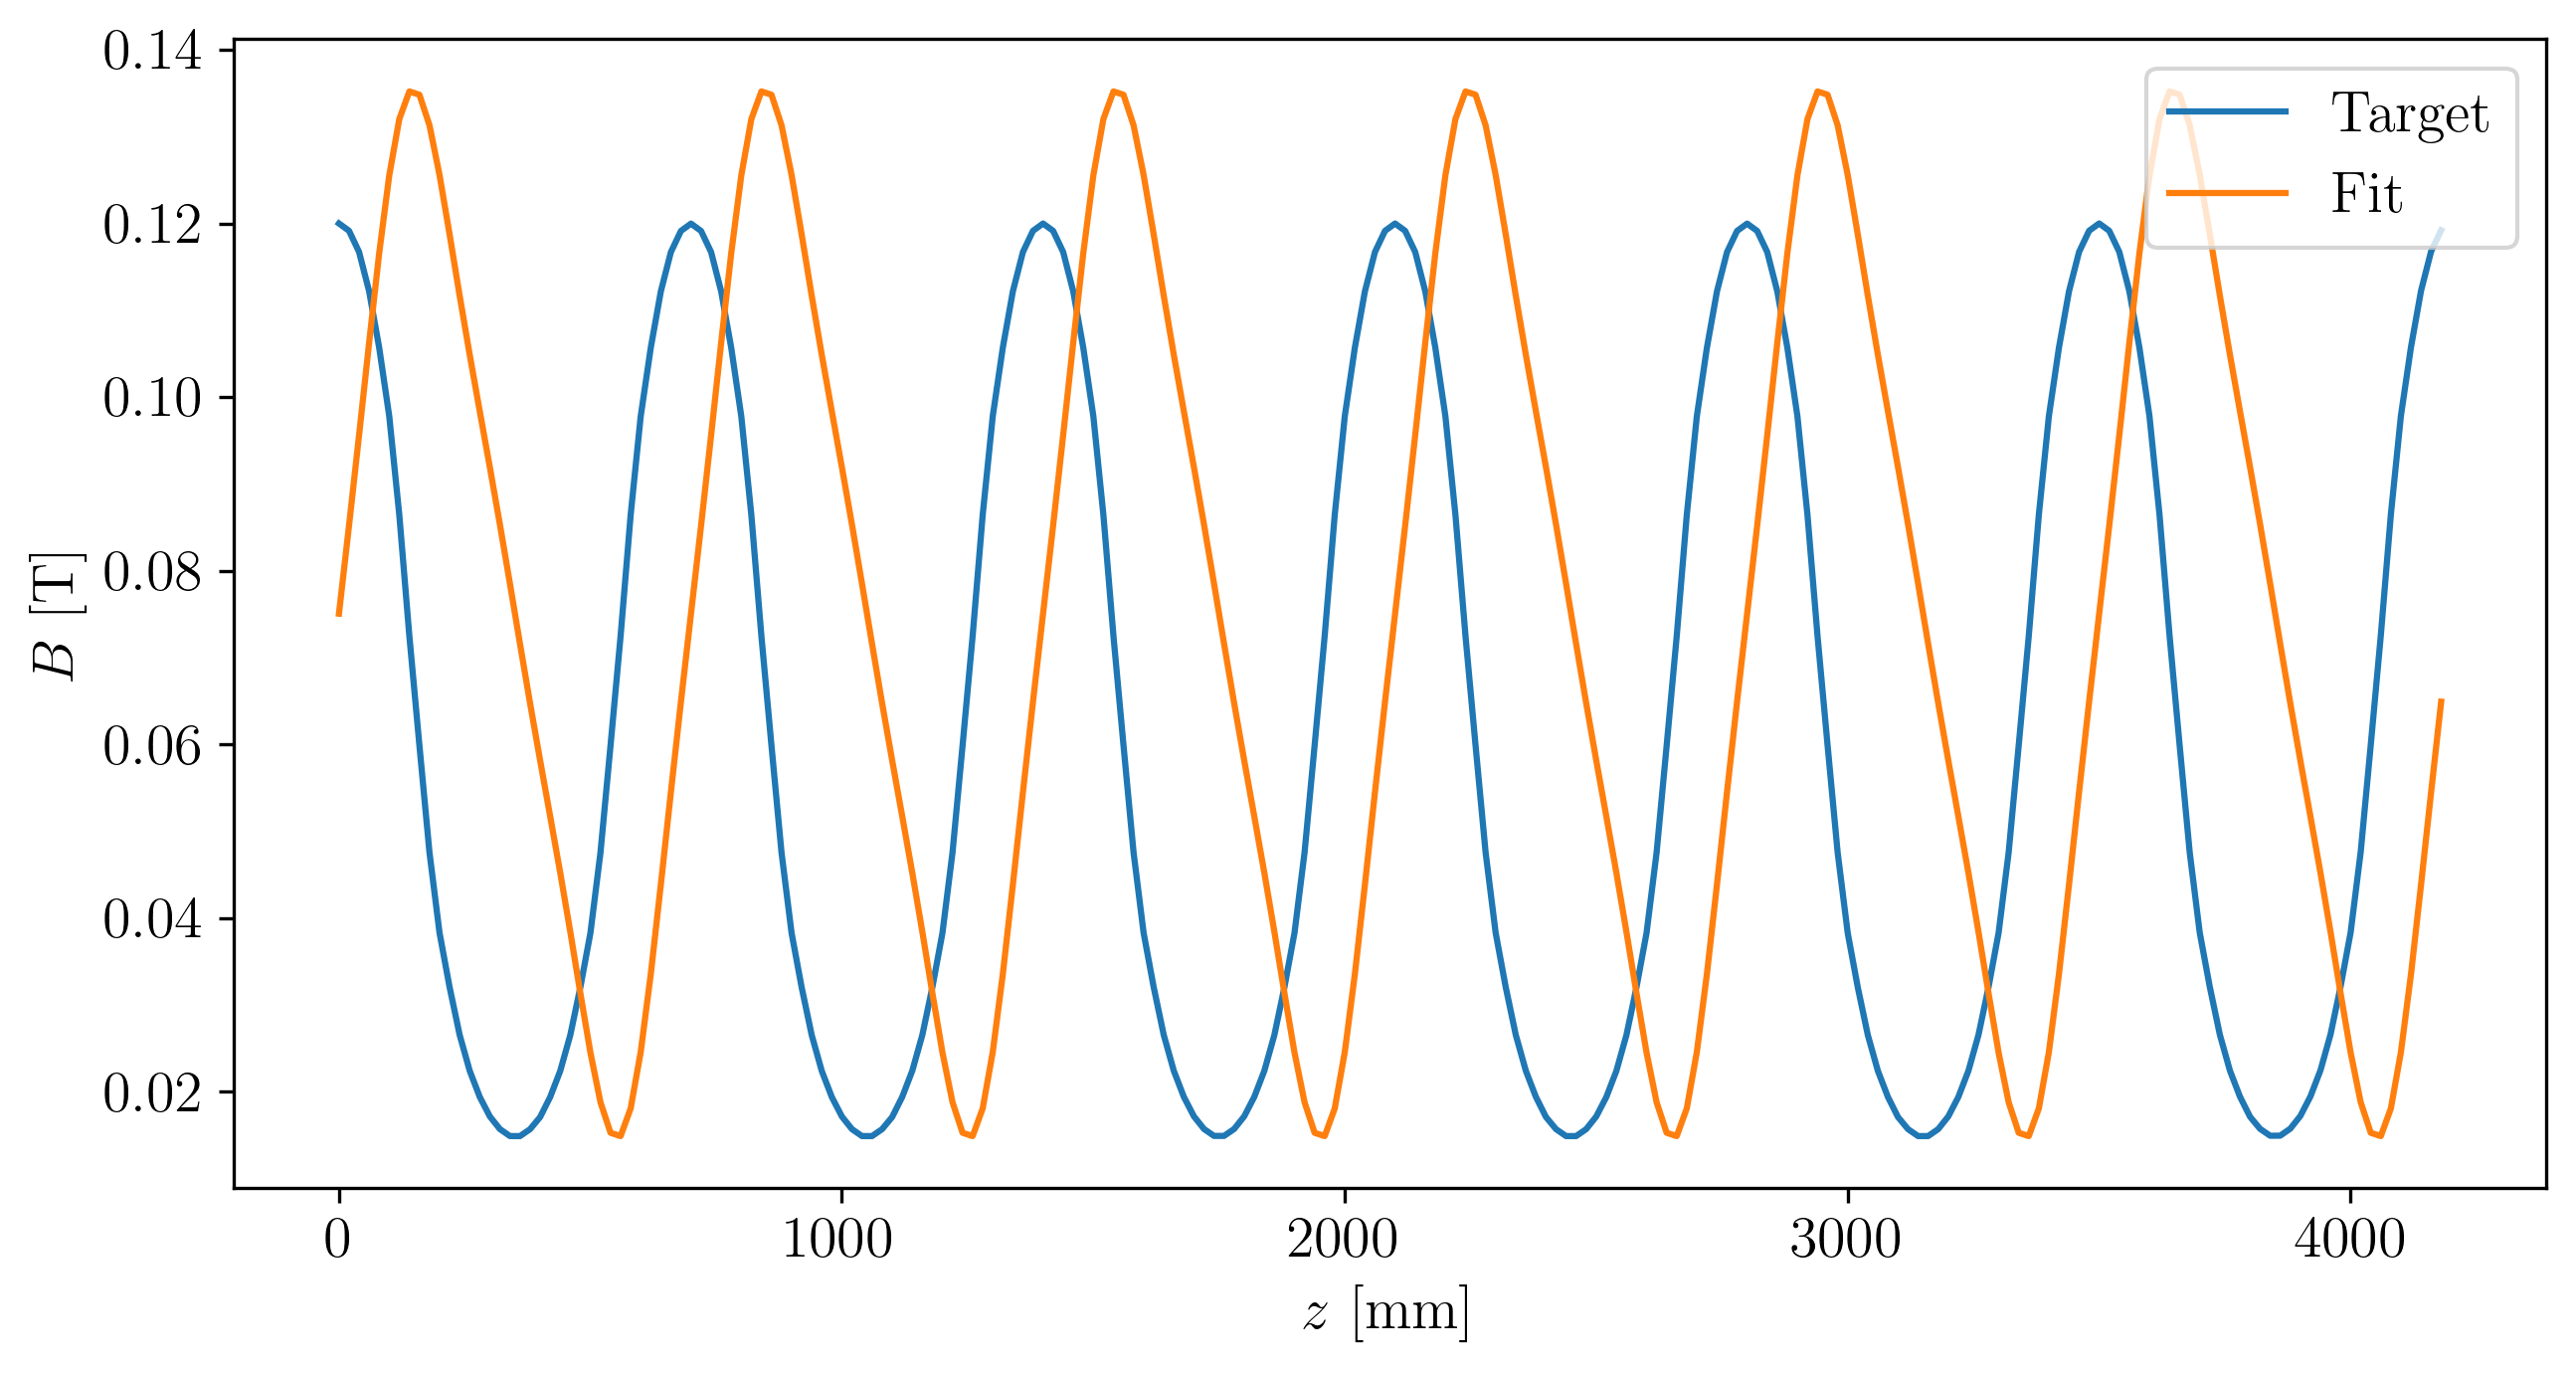

In [27]:
# Correct y offset:
diff = np.min(c) - np.min(recon)

print(f"B(z) = {analytic_form} + {diff}")

plt.figure(figsize=(10, 5))
plt.plot(z, c, label="Target")
plt.plot(z, recon+diff, label="Fit")
plt.legend(loc='upper right')
plt.ylabel("$B$ [T]")
plt.xlabel("$z$ [mm]")
plt.show()

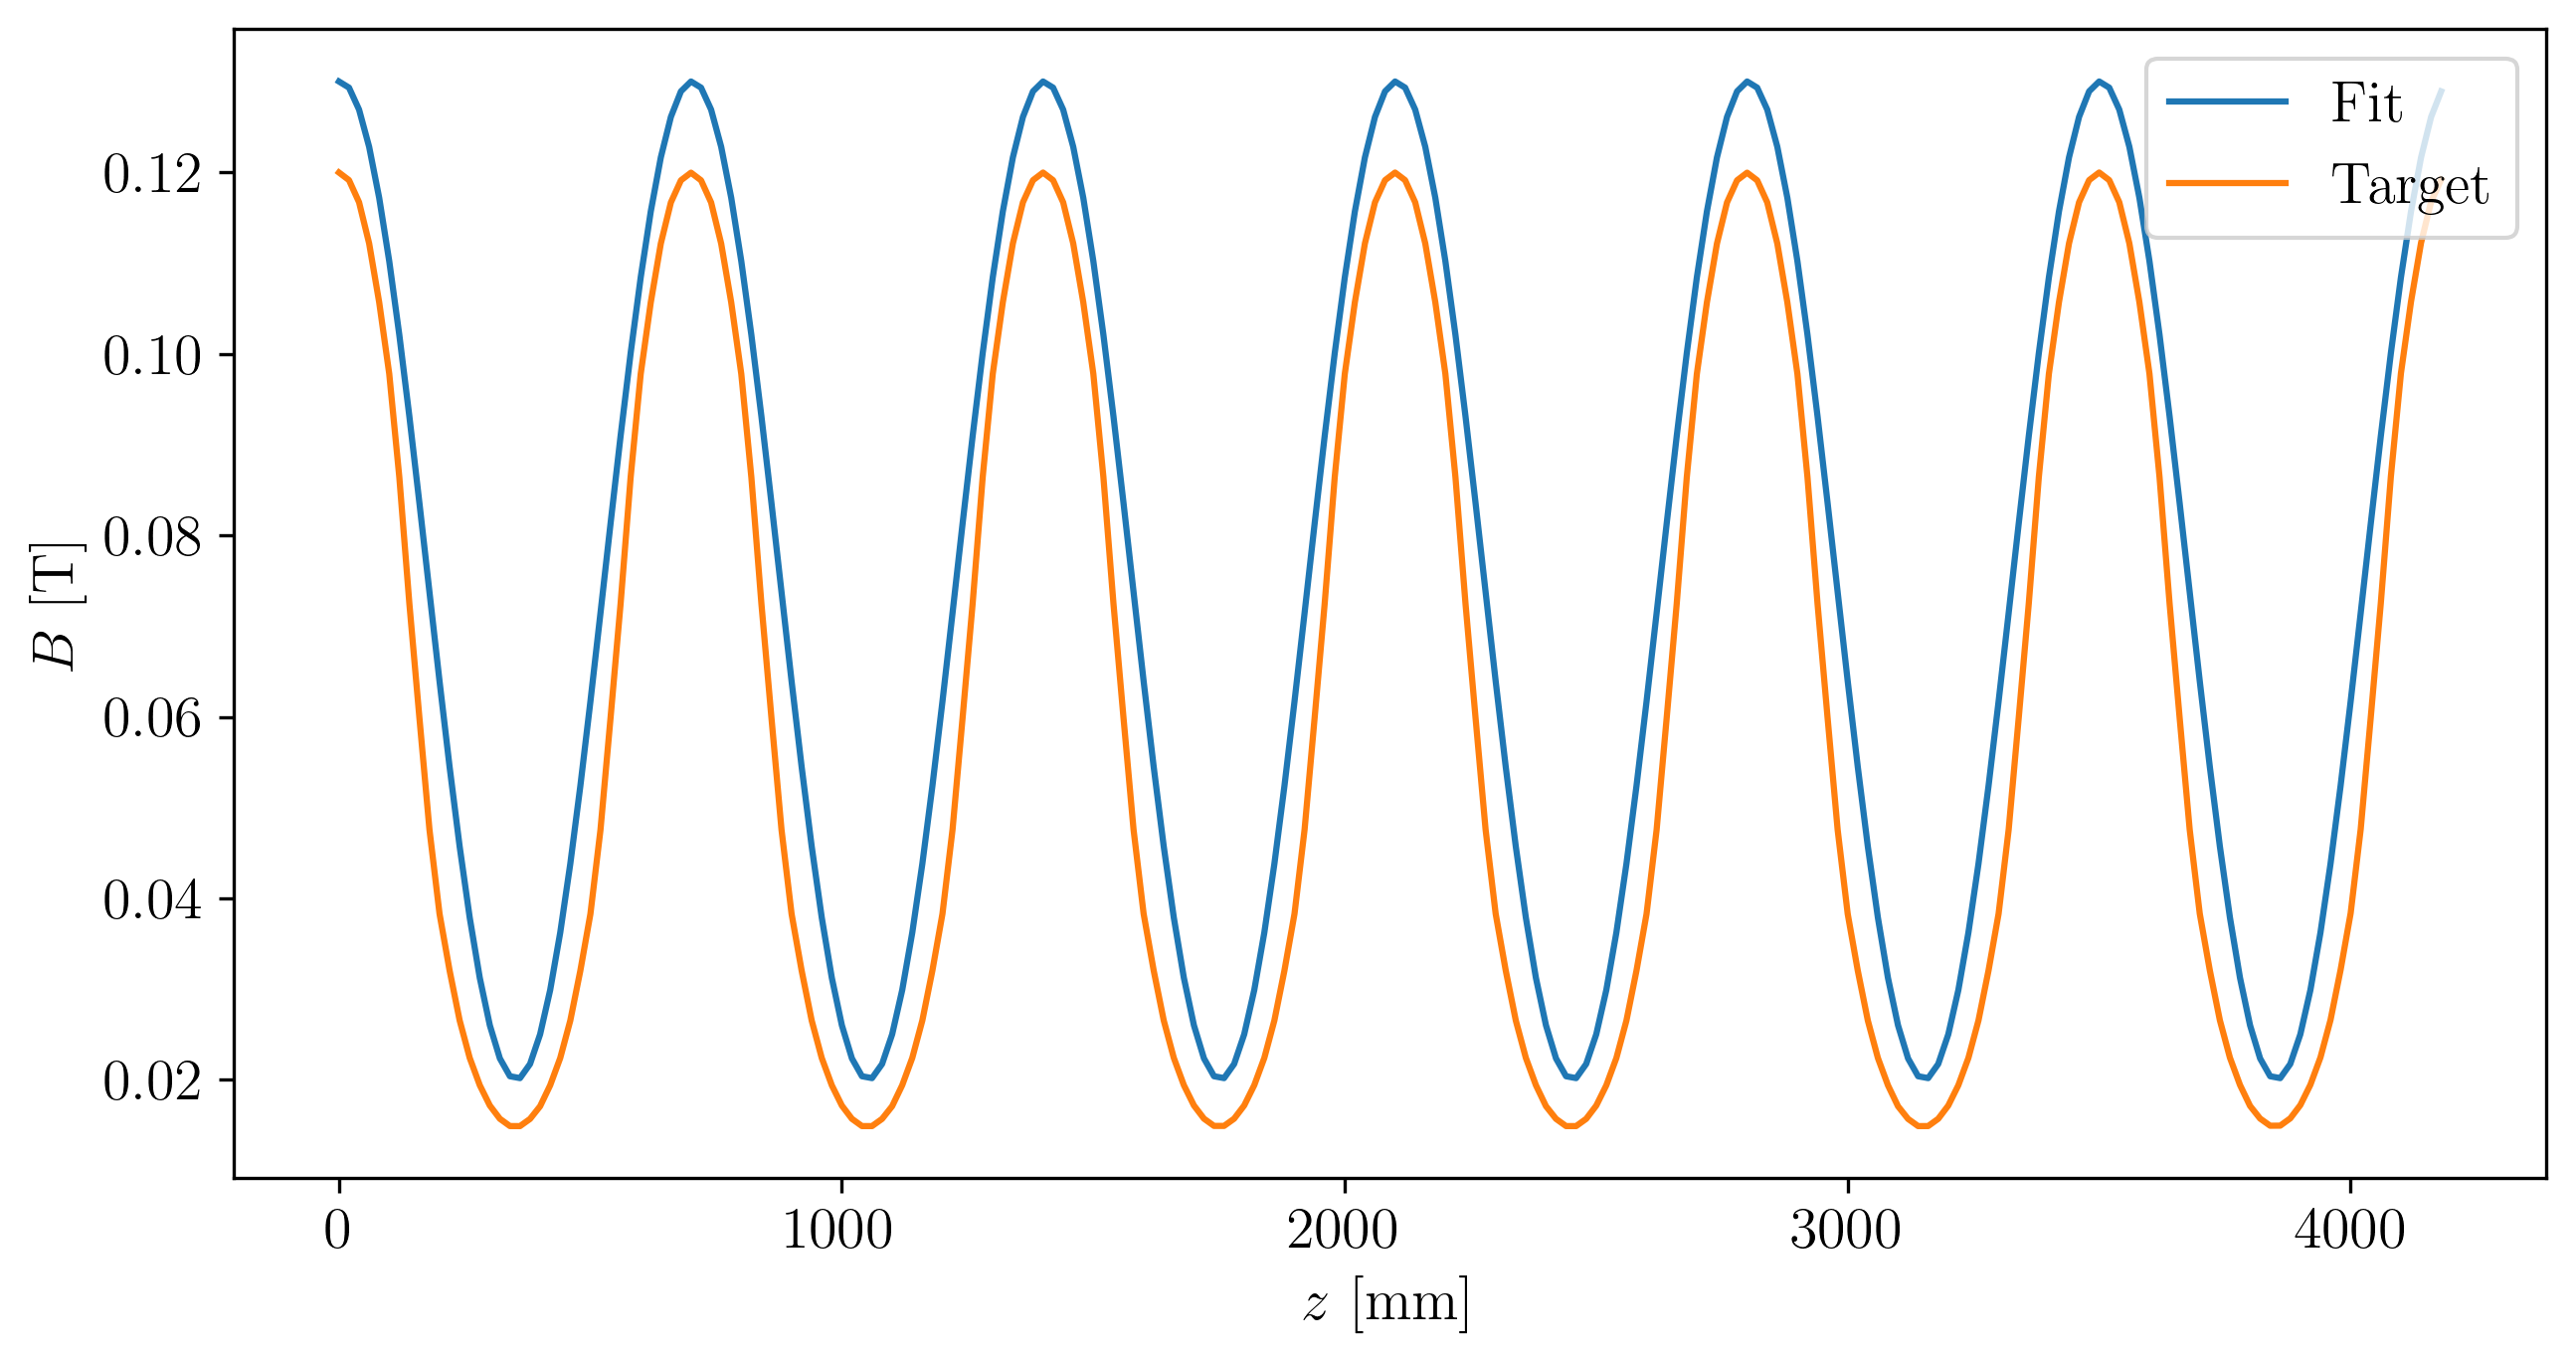

In [28]:
# Tune phase shift by hand:
phi = 1.55

test = 0.055*np.sin(2*np.pi*0.00142857*z+phi) + diff

plt.figure(figsize=(10, 5))
plt.plot(z, test, label='Fit')
plt.plot(z, c, label='Target')
plt.legend(loc='upper right')
plt.ylabel("$B$ [T]")
plt.xlabel("$z$ [mm]")
plt.show()

#### Fit to find analytic expression for magnitude via curve fit:

In [29]:
# Magnitudes of dipole coefficients:
c = df_diff_lim['n=1'].values
z = df_diff_lim['z'].values

In [30]:
def model_func(z, a, k, phi, b):
    return a*np.sin(k*z+phi)+b

# Initial guess based on FFT:
a0 = 0.05489556
k0 = 0.00142857*2*np.pi
phi0 = 1.55
b0 = float(diff)
p0 = [a0, k0, phi0, b0]

popt, pcov = curve_fit(model_func, z, c, p0=p0)
# popt, pcov = curve_fit(model_func, z, c)

In [31]:
print(p0)

[0.05489556, 0.008975970034277542, 1.55, 0.07505787741156027]


In [32]:
print(popt)

[0.05491605 0.00896973 1.58400149 0.06086754]


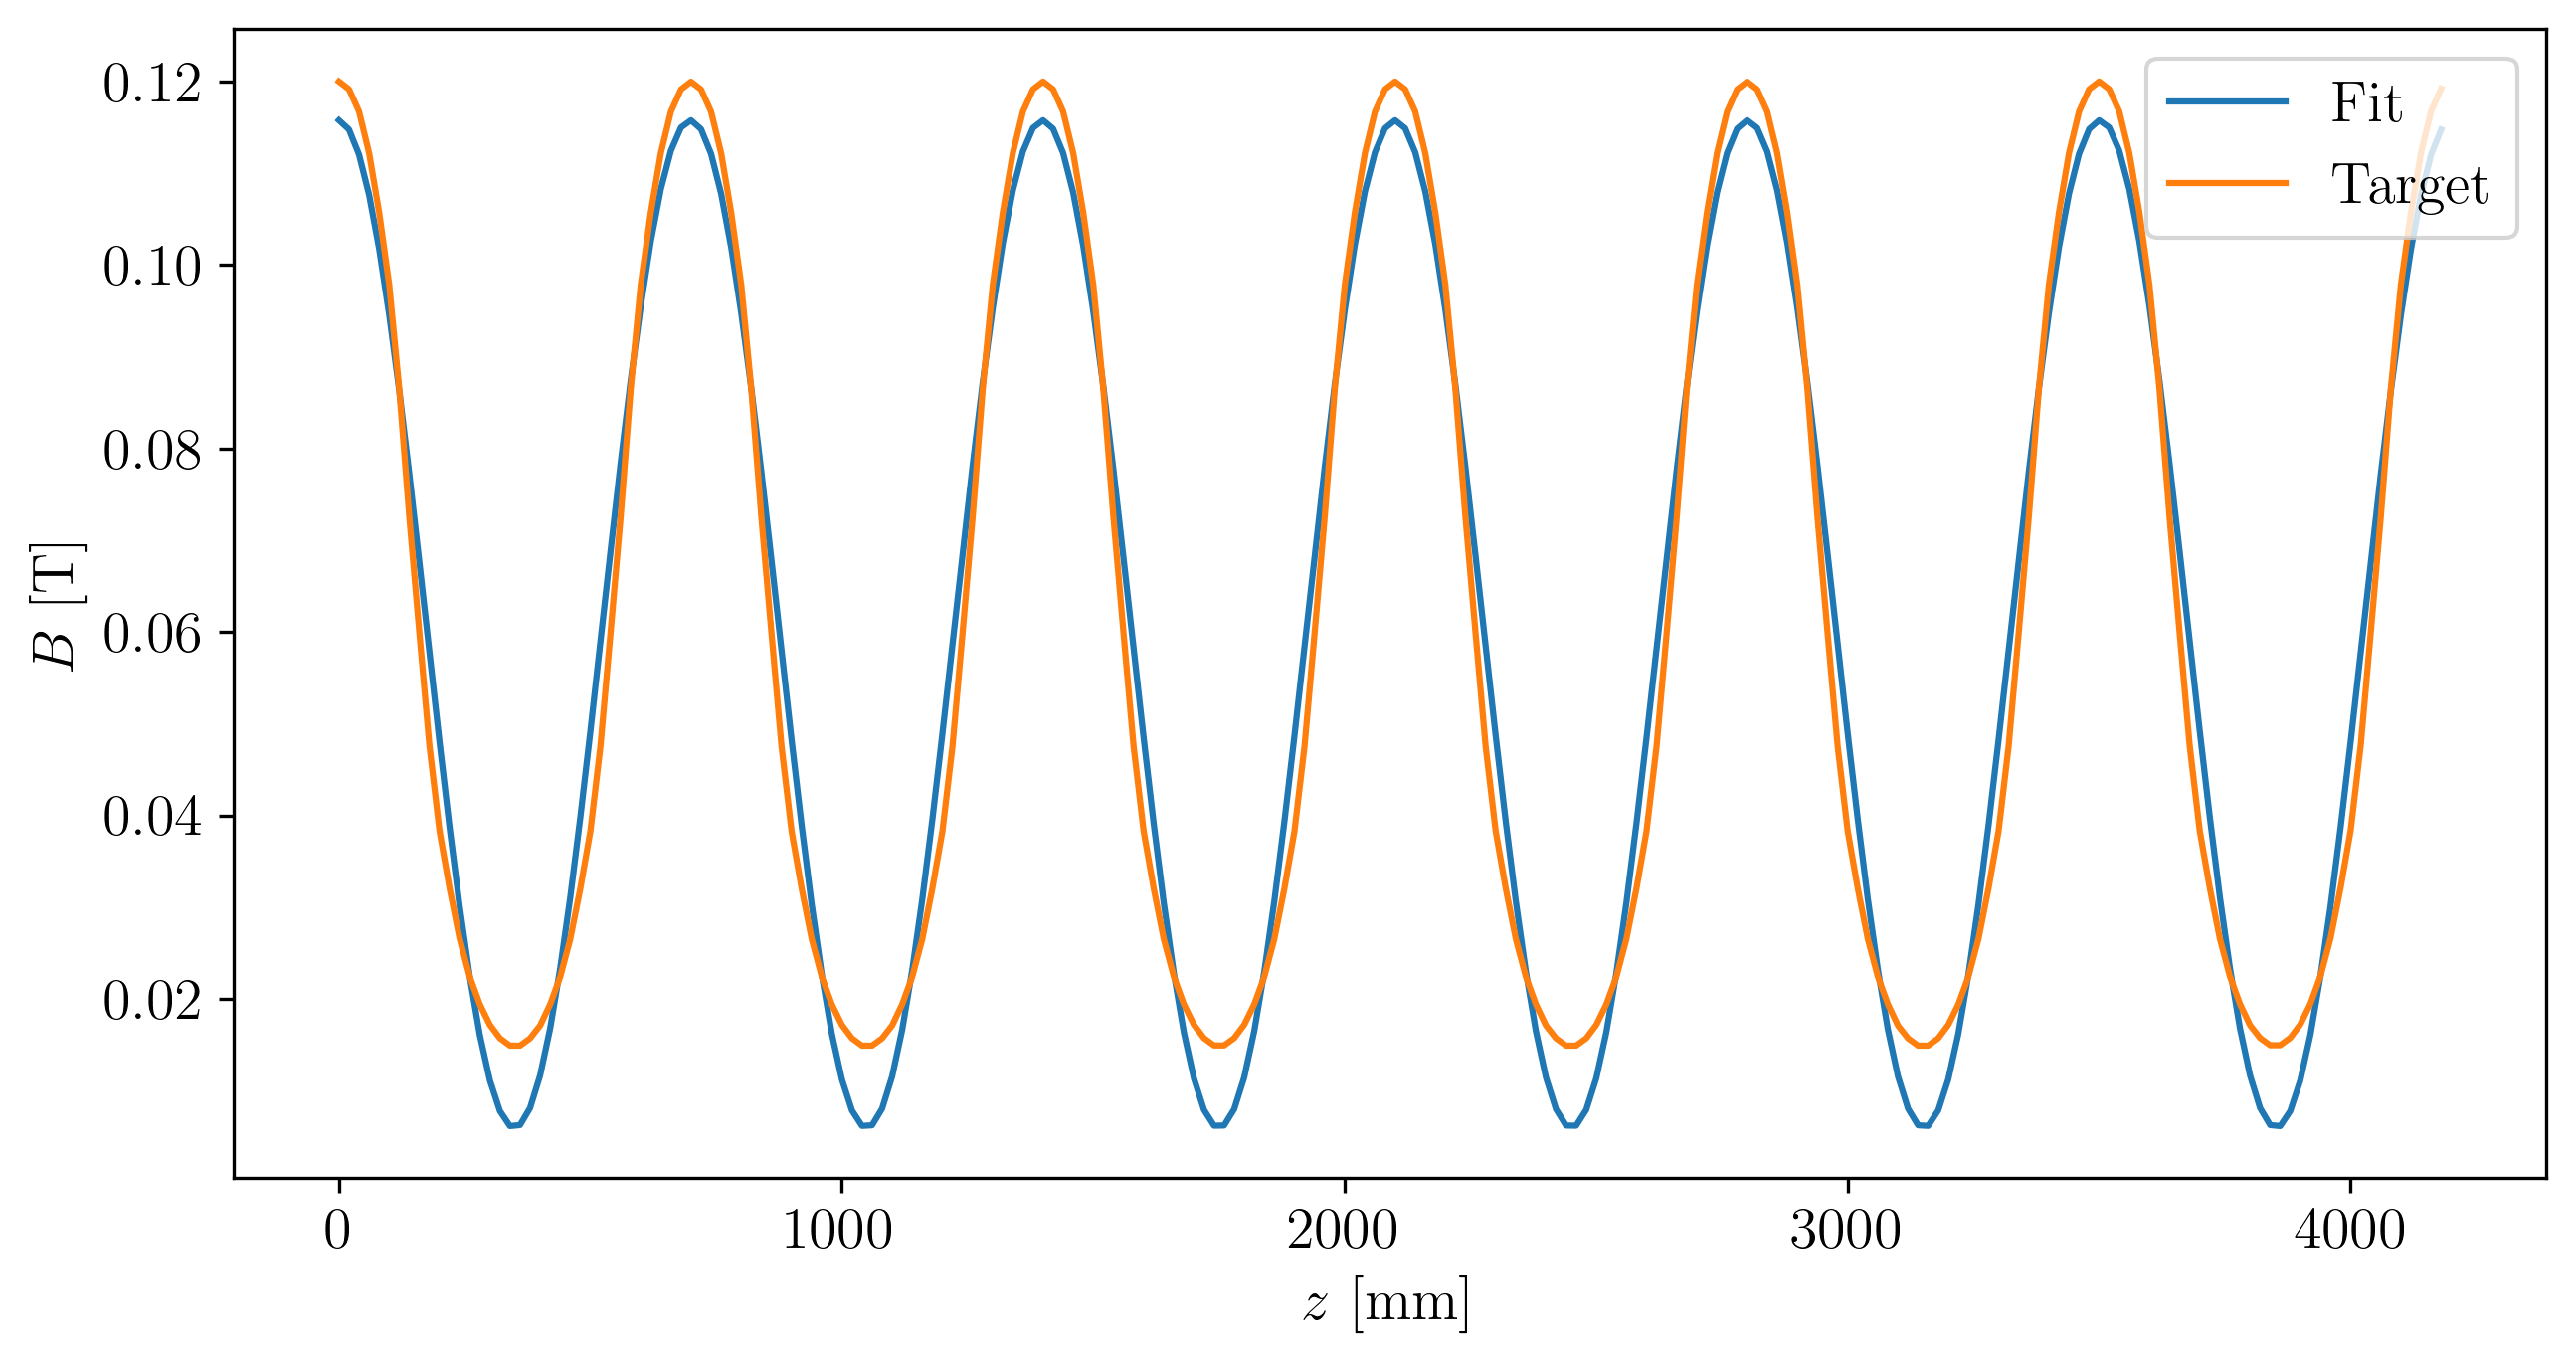

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(z, model_func(z, *popt),label='Fit')
plt.plot(z, c, label='Target')
plt.ylabel("$B$ [T]")
plt.xlabel("$z$ [mm]")
plt.legend(loc='upper right')
plt.show()

In [34]:
def model_func(z, a1, k1, phi1, a2, k2, phi2, a3, k3, phi3, a4, k4, phi4, b):
    return a1*np.sin(k1*z+phi1) + a2*np.sin(k2*z+phi2) + a3*np.sin(k3*z+phi3) + a4*np.sin(k4*z+phi4) + b

# Initial guess based on FFT:
a1init = 0.05489556
k1init = 0.00142857*2*np.pi
phi1init = 0
a2init = 0.00804793
k2init = 0.00285714*2*np.pi
phi2init = 0
a3init = 0.00249592
k3init = 0.00428571*2*np.pi
phi3init = 0
a4init = 0.00184357
k4init = 0.00571429*2*np.pi
phi4init = 0
binit = float(diff)
p0 = [a1init, k1init, phi1init, a2init, k2init, phi2init, a3init, k3init, phi3init, a4init, k4init, phi4init, binit]

popt, pcov = curve_fit(model_func, z, c, p0=p0)

/Users/criggall/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:493: RuntimeWarning: divide by zero encountered in matmul
  cov_x = invR @ invR.T
/Users/criggall/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:493: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/criggall/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:493: RuntimeWarning: invalid value encountered in matmul
  cov_x = invR @ invR.T


In [35]:
print(popt)

[ 0.05489858  0.00897609  1.57066062  0.00805173  0.01795108  1.57273619
  0.00249277  0.02693144 -1.57890505  0.00184459  0.03591906 -1.60272732
  0.06083017]


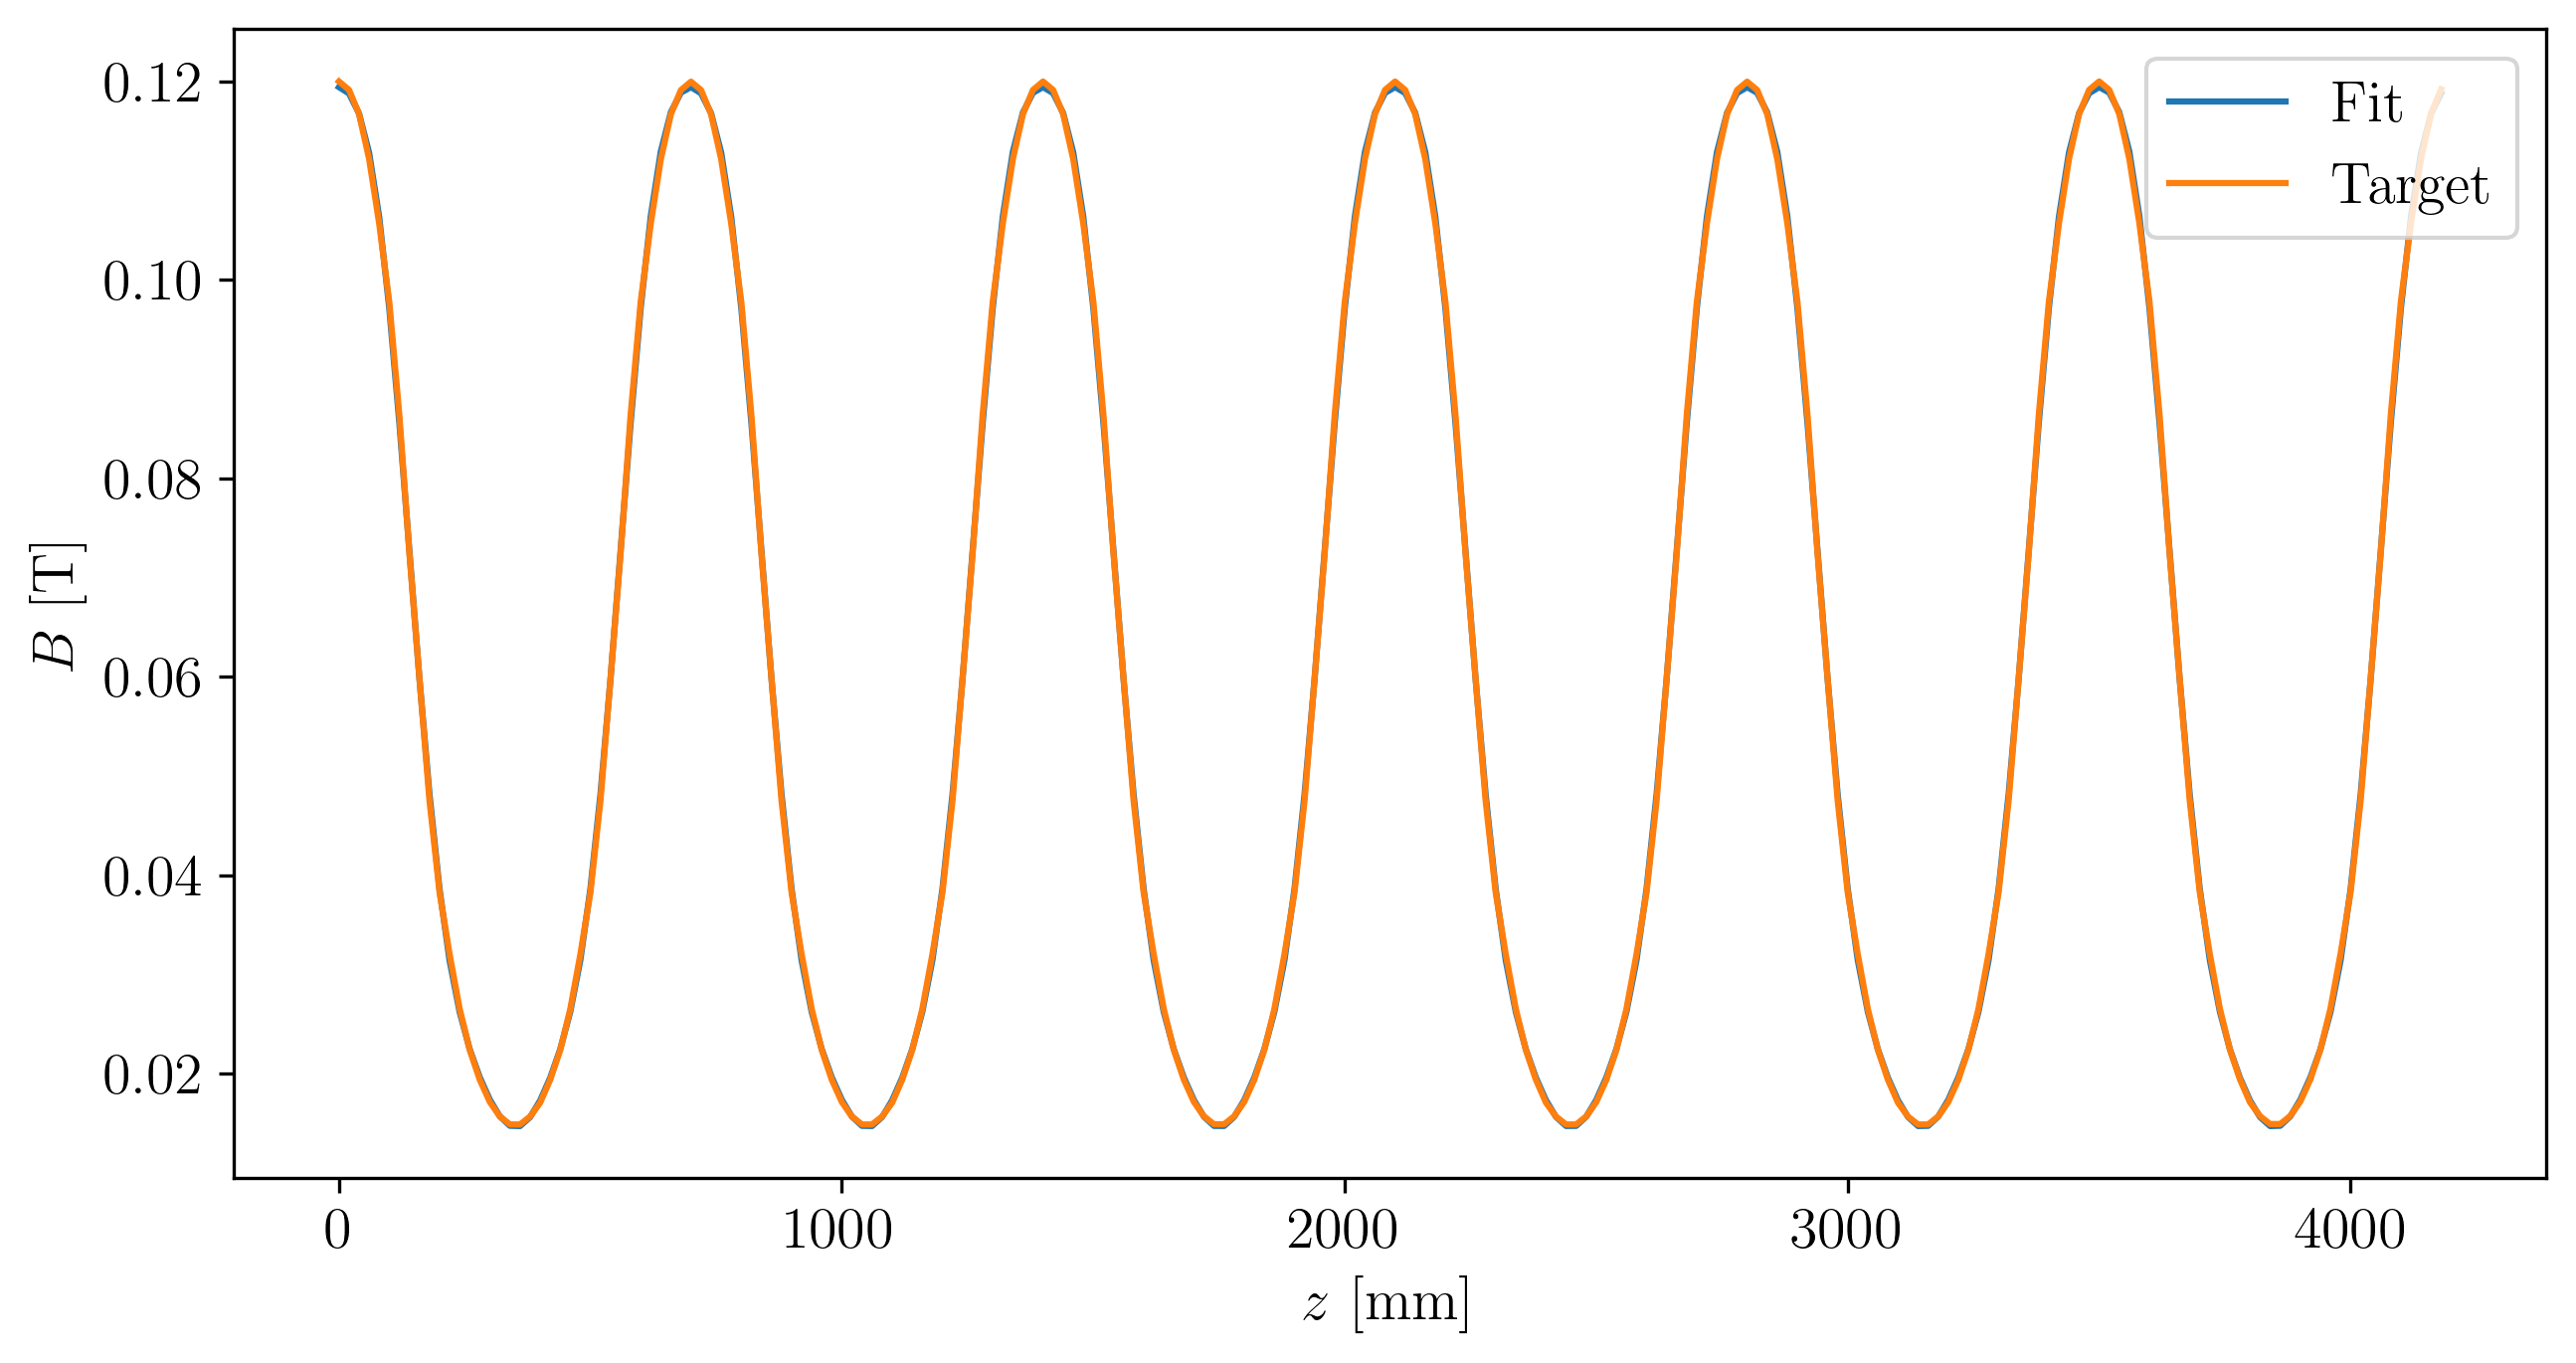

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(z, model_func(z, *popt),label='Fit')
plt.plot(z, c, label='Target')
plt.ylabel("$B$ [T]")
plt.xlabel("$z$ [mm]")
plt.legend(loc='upper right')
plt.show()

#### Construct analytic expression for phases:

In [37]:
import math

def test(z):
    angle = 7*np.pi/4 + math.floor((z-350)/700)
    return angle

In [38]:
zvals = np.arange(0,4200)
angles = []
for z in zvals:
    angles.append(test(z))

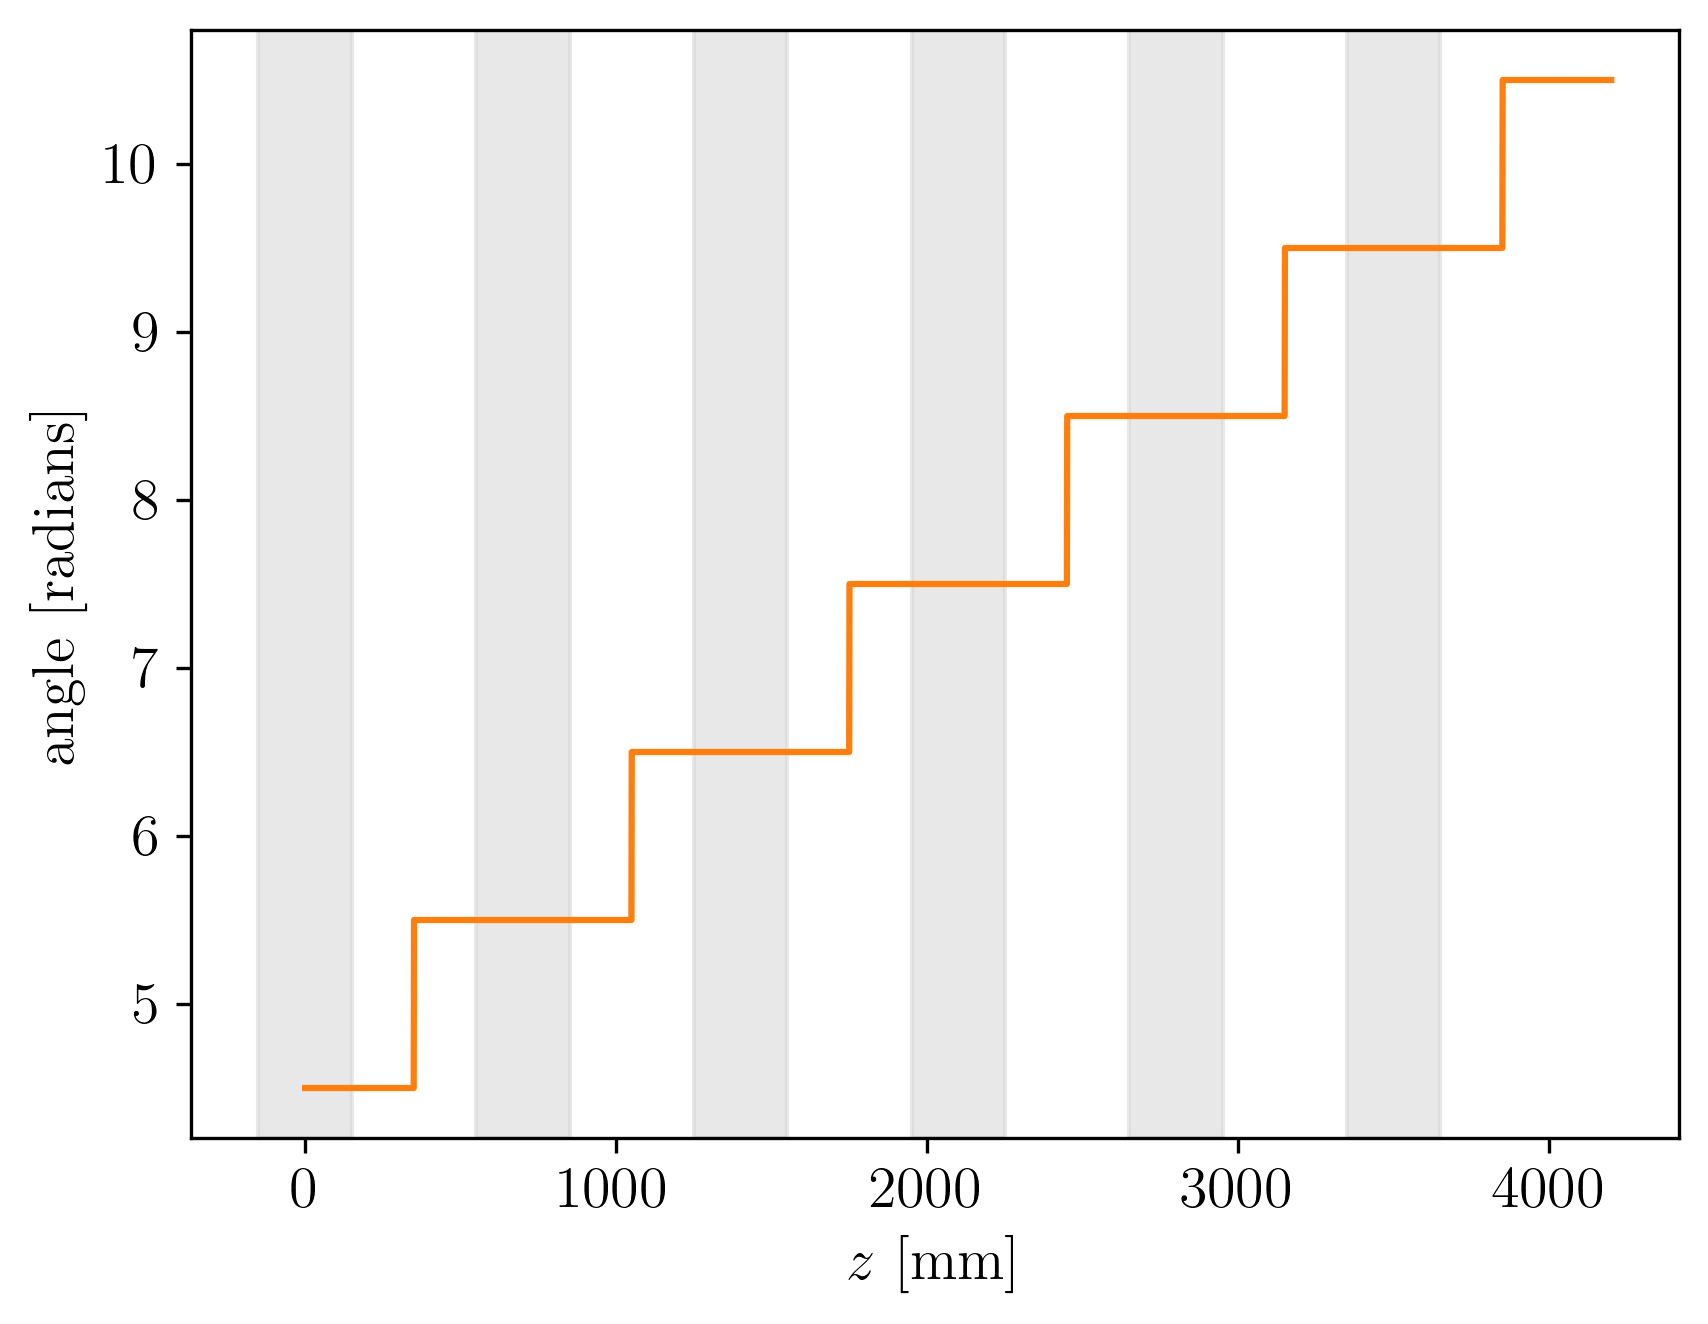

In [39]:
fig, ax = plt.subplots()
plt.plot(zvals,angles, color='tab:orange')
plt.xlabel('$z$ [mm]')
plt.ylabel('angle [radians]')
# plt.xticks([])
# plt.yticks([])
plotLattice(ax)
plt.show()